### Ввод текста

In [ ]:
import json

def read_jsonl_basic(filename):
    """Простое чтение JSONL файла"""
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data

all_news = read_jsonl_basic('/content/tatar_inform_20251022_205733.jsonl')

In [ ]:
texts_list = [item['text'] for item in all_news]

### Этап 2. Реализация классических методов векторизации

#### One-Hot Encoding для слов и n-грамм

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse
from typing import List, Tuple, Union, Dict

In [ ]:
def _analyze_sparsity(matrix: sparse.csr_matrix):
    """
    Анализ разреженности матрицы.

    Args:
        matrix: Разреженная матрица для анализа
    """
    total_elements = matrix.shape[0] * matrix.shape[1]
    non_zero = matrix.nnz
    sparsity = 1 - (non_zero / total_elements)

    print(f"  Разреженность: {sparsity:.4f} ({sparsity*100:.2f}%)")
    print(f"  Плотность: {1-sparsity:.4f} ({(1-sparsity)*100:.2f}%)")
    print(f"  Эффективность хранения: {matrix.data.nbytes / (total_elements * 8):.4f}")
    print()

In [ ]:
def one_hot_encoding(texts: List[str], ngram_range: Tuple[int, int] = (1, 1),
                    analyzer: str = 'word') -> sparse.csr_matrix:
    """
    One-Hot Encoding для текстов с поддержкой n-грамм.

    Args:
        texts: Список текстов для векторизации
        ngram_range: Диапазон n-грамм (min_n, max_n)
        analyzer: Тип анализа ('word' или 'char')

    Returns:
        Разреженная матрица one-hot encoding
    """
    vectorizer = CountVectorizer(
        binary=True,
        ngram_range=ngram_range,
        analyzer=analyzer,
        token_pattern=None if analyzer == 'char' else r'\b\w+\b'
    )

    onehot_matrix = vectorizer.fit_transform(texts)

    print(f"One-Hot Encoding (n-grams {ngram_range}):")
    print(f"  Создано признаков: {onehot_matrix.shape[1]}")
    _analyze_sparsity(onehot_matrix)

    return onehot_matrix

In [ ]:
one_hot_encoding(texts_list)

One-Hot Encoding (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516



<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 69630 stored elements and shape (600, 2251)>

#### Bag of Words с различными схемами взвешивания

In [ ]:
def bag_of_words(texts: List[str], ngram_range: Tuple[int, int] = (1, 1),
                weighting_scheme: str = 'count', binary: bool = False,
                min_df: Union[int, float] = 1, max_df: Union[int, float] = 1.0) -> sparse.csr_matrix:
    """
    Bag of Words с различными схемами взвешивания.

    Args:
        texts: Список текстов для векторизации
        ngram_range: Диапазон n-грамм (min_n, max_n)
        weighting_scheme: Схема взвешивания ('count', 'binary', 'freq')
        binary: Бинарные веса (True/False)
        min_df: Минимальная частота документа
        max_df: Максимальная частота документа

    Returns:
        Разреженная матрица Bag of Words
    """
    if weighting_scheme == 'binary':
        binary = True

    vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        binary=binary,
        min_df=min_df,
        max_df=max_df,
        token_pattern=r'\b\w+\b'
    )

    bow_matrix = vectorizer.fit_transform(texts)

    if weighting_scheme == 'freq':
        bow_matrix = bow_matrix.astype(float)
        doc_lengths = bow_matrix.sum(axis=1)
        bow_matrix = bow_matrix / np.maximum(doc_lengths, 1)

    print(f"Bag of Words ({weighting_scheme}, n-grams {ngram_range}):")
    print(f"  Создано признаков: {bow_matrix.shape[1]}")
    _analyze_sparsity(bow_matrix)

    return bow_matrix


count - режим

In [ ]:
bag_of_words(texts_list)

Bag of Words (count, n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516



<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 69630 stored elements and shape (600, 2251)>

freq - режим

In [ ]:
bag_of_words(texts_list, weighting_scheme='freq')

Bag of Words (freq, n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516



<COOrdinate sparse matrix of dtype 'float64'
	with 69630 stored elements and shape (600, 2251)>

#### TF-IDF с настройкой параметров (smooth_idf, sublinear_tf)

In [ ]:
def tfidf_vectorization(texts: List[str], ngram_range: Tuple[int, int] = (1, 1),
                       smooth_idf: bool = True, sublinear_tf: bool = False,
                       min_df: Union[int, float] = 1, max_df: Union[int, float] = 1.0,
                       use_idf: bool = True) -> sparse.csr_matrix:
    """
    TF-IDF векторизация с настройкой параметров.

    Args:
        texts: Список текстов для векторизации
        ngram_range: Диапазон n-грамм (min_n, max_n)
        smooth_idf: Сглаживание IDF
        sublinear_tf: Сублинейное масштабирование TF
        min_df: Минимальная частота документа
        max_df: Максимальная частота документа
        use_idf: Использовать IDF веса

    Returns:
        Разреженная матрица TF-IDF
    """
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        smooth_idf=smooth_idf,
        sublinear_tf=sublinear_tf,
        min_df=min_df,
        max_df=max_df,
        use_idf=use_idf,
        token_pattern=r'\b\w+\b'
    )

    tfidf_matrix = vectorizer.fit_transform(texts)

    scheme_name = "TF-IDF" if use_idf else "TF"
    params = []
    if smooth_idf:
        params.append("smooth_idf")
    if sublinear_tf:
        params.append("sublinear_tf")

    param_str = f" ({', '.join(params)})" if params else ""

    print(f"{scheme_name}{param_str} (n-grams {ngram_range}):")
    print(f"  Создано признаков: {tfidf_matrix.shape[1]}")
    _analyze_sparsity(tfidf_matrix)

    return tfidf_matrix

sublinear_tf = False, smooth_idf = True

In [ ]:
tfidf_vectorization(texts_list)

TF-IDF (smooth_idf) (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516



<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 69630 stored elements and shape (600, 2251)>

sublinear_tf = True, smooth_idf = False

In [ ]:
tfidf_vectorization(texts_list, sublinear_tf = True, smooth_idf = False)

TF-IDF (sublinear_tf) (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516



<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 69630 stored elements and shape (600, 2251)>

####  Этап 3. Снижение размерности и тематическое моделирование

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import pairwise_distances
from typing import List, Tuple, Dict, Any, Optional
import pandas as pd

In [ ]:
def apply_svd(matrix, n_components: int = 100, random_state: int = 42) -> Tuple[np.ndarray, Any]:
    """
    Применение SVD (LSA) для выявления скрытых семантических тем.

    Args:
        matrix: Входная матрица признаков
        n_components: Количество компонент для сохранения
        random_state: Seed для воспроизводимости

    Returns:
        (уменьшенная_матрица, svd_модель)
    """
    svd_model = TruncatedSVD(
        n_components=n_components,
        random_state=random_state
    )

    reduced_matrix = svd_model.fit_transform(matrix)

    explained_variance = svd_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print(f"SVD применен: {matrix.shape} -> {reduced_matrix.shape}")
    print(f"Сохранено дисперсии: {cumulative_variance[-1]:.4f} "
          f"({cumulative_variance[-1]*100:.2f}%)")

    return reduced_matrix, svd_model

In [ ]:
matrix = tfidf_vectorization(texts_list)
apply_svd(matrix, n_components=25)

TF-IDF (smooth_idf) (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516

SVD применен: (600, 2251) -> (600, 25)
Сохранено дисперсии: 0.8681 (86.81%)


(array([[ 0.21510616, -0.01369586,  0.03734443, ...,  0.05328836,
         -0.07978181,  0.05506849],
        [ 0.17579227,  0.75942871,  0.20808167, ..., -0.0121633 ,
          0.02851183, -0.00326557],
        [ 0.31782422, -0.03959491, -0.20475953, ...,  0.13063339,
          0.18452619,  0.20060822],
        ...,
        [ 0.18315829,  0.01470134, -0.26790622, ...,  0.14065956,
         -0.00231865, -0.06612355],
        [ 0.23779708, -0.06294627, -0.1045891 , ..., -0.30991848,
          0.06966274,  0.27124199],
        [ 0.18576955, -0.02026848, -0.00610448, ..., -0.11152576,
          0.06043606,  0.03837226]]),
 TruncatedSVD(n_components=25, random_state=42))

In [ ]:
def find_optimal_components(matrix, variance_threshold: float = 0.95,
                          max_components: int = 500, random_state: int = 42) -> Tuple[int, np.ndarray, Any]:
    """
    Автоматический подбор числа компонент для сохранения заданной дисперсии.

    Args:
        matrix: Входная матрица
        variance_threshold: Порог сохраняемой дисперсии (0-1)
        max_components: Максимальное число компонент для проверки
        random_state: Seed для воспроизводимости

    Returns:
        (оптимальное_число_компонент, уменьшенная_матрица, svd_модель)
    """
    actual_max_components = min(max_components, matrix.shape[1] - 1, matrix.shape[0] - 1)

    svd_model = TruncatedSVD(
        n_components=actual_max_components,
        random_state=random_state
    )

    reduced_matrix = svd_model.fit_transform(matrix)
    explained_variance = svd_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Оптимальное число компонент: {optimal_components}")
    print(f"Сохраняемая дисперсия: {cumulative_variance[optimal_components-1]:.4f}")

    if optimal_components < actual_max_components:
        svd_model = TruncatedSVD(
            n_components=optimal_components,
            random_state=random_state
        )
        reduced_matrix = svd_model.fit_transform(matrix)

    return optimal_components, reduced_matrix, svd_model

In [ ]:
matrix = tfidf_vectorization(texts_list)
find_optimal_components(matrix, variance_threshold=0.87, max_components=30)

TF-IDF (smooth_idf) (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516

Оптимальное число компонент: 26
Сохраняемая дисперсия: 0.8972


(np.int64(26),
 array([[ 0.21510616, -0.01369586,  0.03734443, ..., -0.07978181,
          0.05506849, -0.08847684],
        [ 0.17579227,  0.75942871,  0.20808167, ...,  0.02851183,
         -0.00326557, -0.00878112],
        [ 0.31782422, -0.03959491, -0.20475953, ...,  0.18452619,
          0.20060822, -0.20997069],
        ...,
        [ 0.18315829,  0.01470134, -0.26790622, ..., -0.00231865,
         -0.06612355, -0.28109685],
        [ 0.23779708, -0.06294627, -0.1045891 , ...,  0.06966274,
          0.27124199, -0.04197857],
        [ 0.18576955, -0.02026848, -0.00610448, ...,  0.06043606,
          0.03837226, -0.0512843 ]]),
 TruncatedSVD(n_components=np.int64(26), random_state=42))

In [ ]:
def visualize_variance(svd_model, max_components: int = 50) -> plt.Figure:
    """
    Визуализация объясненной дисперсии от числа компонент.

    Args:
        svd_model: Обученная SVD модель
        max_components: Максимальное число компонент для отображения

    Returns:
        Figure с графиком
    """
    explained_variance = svd_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    components_to_show = min(max_components, len(explained_variance))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.bar(range(1, components_to_show + 1),
            explained_variance[:components_to_show],
            alpha=0.7, color='skyblue')
    ax1.set_xlabel('Номер компоненты')
    ax1.set_ylabel('Объясненная дисперсия')
    ax1.set_title('Объясненная дисперсия по компонентам')
    ax1.grid(True, alpha=0.3)

    ax2.plot(range(1, components_to_show + 1),
             cumulative_variance[:components_to_show],
             marker='o', linewidth=2, markersize=4)
    ax2.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% дисперсии')
    ax2.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% дисперсии')
    ax2.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% дисперсии')
    ax2.set_xlabel('Число компонент')
    ax2.set_ylabel('Кумулятивная дисперсия')
    ax2.set_title('Накопленная объясненная дисперсия')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

TF-IDF (smooth_idf) (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516

Оптимальное число компонент: 26
Сохраняемая дисперсия: 0.8972


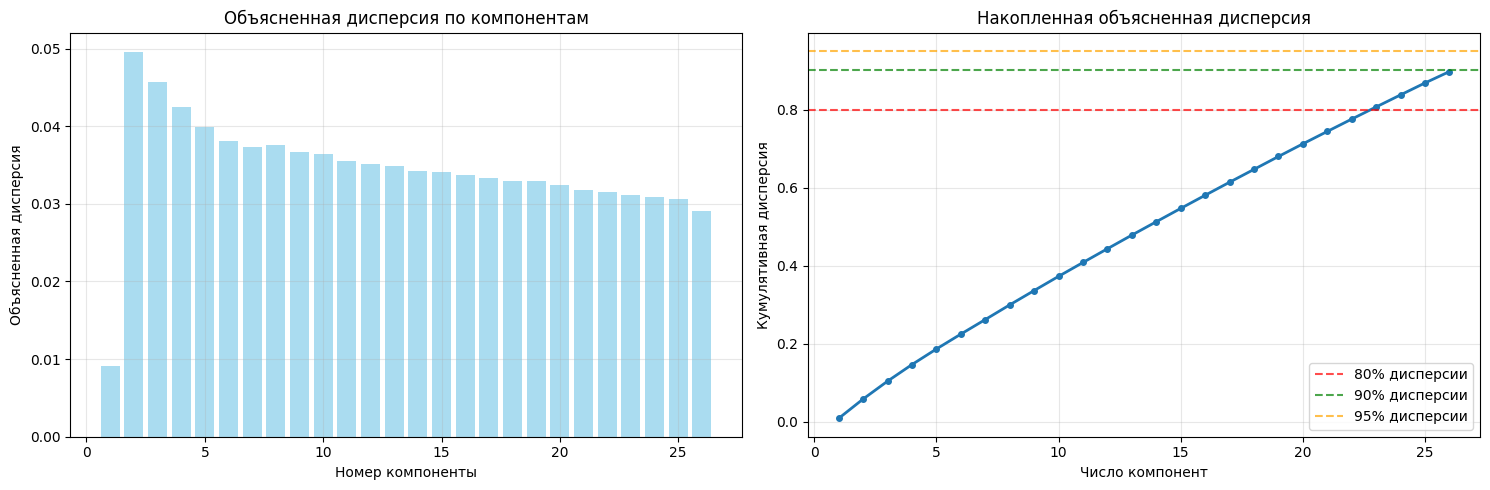

In [ ]:
matrix = tfidf_vectorization(texts_list)
optimal_components, reduced_matrix, svd_model = find_optimal_components(matrix, variance_threshold=0.87, max_components=30)
fig = visualize_variance(svd_model, optimal_components)
plt.show()

In [ ]:
def analyze_components(svd_model, feature_names: List[str],
                     n_top_words: int = 10,
                     n_components: int = 10) -> Dict[int, List[Tuple[str, float]]]:
    """
    Интерпретация компонент через ключевые слова.

    Args:
        svd_model: Обученная SVD модель
        feature_names: Названия признаков
        n_top_words: Количество ключевых слов для каждой компоненты
        n_components: Число компонент для анализа

    Returns:
        Словарь {номер_компоненты: [(слово, вес), ...]}
    """
    components = svd_model.components_
    n_components = min(n_components, components.shape[0])

    component_keywords = {}

    print("=" * 60)
    print("ИНТЕРПРЕТАЦИЯ КОМПОНЕНТ (скрытые темы)")
    print("=" * 60)

    for i in range(n_components):
        top_indices = np.argsort(components[i])[-n_top_words:][::-1]
        top_words = [(feature_names[j], components[i][j])
                    for j in top_indices]

        component_keywords[i] = top_words

        print(f"\nКомпонента {i + 1}:")
        for word, weight in top_words:
            print(f"  {word}: {weight:.4f}")

    return component_keywords


In [ ]:
def tfidf_vectorization_with_names(texts: List[str], ngram_range: Tuple[int, int] = (1, 1),
                                  smooth_idf: bool = True, sublinear_tf: bool = False,
                                  min_df: Union[int, float] = 1, max_df: Union[int, float] = 1.0,
                                  use_idf: bool = True) -> Tuple[sparse.csr_matrix, Any, List[str]]:
    """
    TF-IDF векторизация с возвратом feature_names.

    Returns:
        (матрица, векторaйзер, feature_names)
    """
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        smooth_idf=smooth_idf,
        sublinear_tf=sublinear_tf,
        min_df=min_df,
        max_df=max_df,
        use_idf=use_idf,
        token_pattern=r'\b\w+\b'
    )

    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out().tolist()

    scheme_name = "TF-IDF" if use_idf else "TF"
    params = []
    if smooth_idf:
        params.append("smooth_idf")
    if sublinear_tf:
        params.append("sublinear_tf")

    param_str = f" ({', '.join(params)})" if params else ""

    print(f"{scheme_name}{param_str} (n-grams {ngram_range}):")
    print(f"  Создано признаков: {tfidf_matrix.shape[1]}")
    _analyze_sparsity(tfidf_matrix)

    return tfidf_matrix, vectorizer, feature_names

In [ ]:
tfidf_matrix, vectorizer, feature_names = tfidf_vectorization_with_names(texts_list)
optimal_components, reduced_matrix, svd_model = find_optimal_components(tfidf_matrix, variance_threshold=0.87, max_components=30)
analyze_components(svd_model, feature_names, n_top_words=5)

TF-IDF (smooth_idf) (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516

Оптимальное число компонент: 26
Сохраняемая дисперсия: 0.8972
ИНТЕРПРЕТАЦИЯ КОМПОНЕНТ (скрытые темы)

Компонента 1:
  һәм: 0.3318
  белән: 0.1756
  шаян: 0.1347
  татар: 0.1315
  ул: 0.1288

Компонента 2:
  сәгатьтә: 0.2322
  кертелде: 0.2081
  07: 0.2081
  режимы: 0.1841
  пилотсыз: 0.1841

Компонента 3:
  шаян: 0.2445
  шортс: 0.1399
  балалар: 0.1302
  яшь: 0.1132
  без: 0.1009

Компонента 4:
  махсус: 0.2069
  хәрби: 0.1909
  операция: 0.1229
  ватанны: 0.1165
  саклаучылар: 0.1165

Компонента 5:
  татар: 0.1829
  үлгән: 0.1282
  ставканы: 0.0958
  хәйдәр: 0.0953
  яшьлек: 0.0951

Компонента 6:
  ана: 0.1730
  татар: 0.1020
  ата: 0.1005
  үлгән: 0.1001
  мең: 0.0957

Компонента 7:
  вяткина: 0.2188
  генераль: 0.1765
  китте: 0.1537
  алиса: 0.1459
  иттеләр: 0.1459

Компонента 8:
  үлгән: 0.1552
  яшьлек: 0.1130
  батып: 0.

{0: [('һәм', np.float64(0.33179529349560855)),
  ('белән', np.float64(0.1756147747385571)),
  ('шаян', np.float64(0.13466612272441714)),
  ('татар', np.float64(0.13145814462018346)),
  ('ул', np.float64(0.12880157276162912))],
 1: [('сәгатьтә', np.float64(0.23224629101531225)),
  ('кертелде', np.float64(0.20808538659776873)),
  ('07', np.float64(0.20808538659776862)),
  ('режимы', np.float64(0.18409402425950497)),
  ('пилотсыз', np.float64(0.18409402425950497))],
 2: [('шаян', np.float64(0.2445326510542232)),
  ('шортс', np.float64(0.1398642722226441)),
  ('балалар', np.float64(0.13017165531889496)),
  ('яшь', np.float64(0.11321458704657615)),
  ('без', np.float64(0.10087309267925383))],
 3: [('махсус', np.float64(0.2068856207260316)),
  ('хәрби', np.float64(0.19087531388366963)),
  ('операция', np.float64(0.12293482352246375)),
  ('ватанны', np.float64(0.11650543121847316)),
  ('саклаучылар', np.float64(0.11650543121847316))],
 4: [('татар', np.float64(0.18288968700427202)),
  ('үлгән

АНАЛИЗ СТАБИЛЬНОСТИ ТЕМ

Анализ для 10 компонент:
Средняя стабильность тем: 0.4765
Минимальная стабильность: 0.0361
Максимальная стабильность: 1.0000

Анализ для 20 компонент:
Средняя стабильность тем: 0.9540
Минимальная стабильность: 0.4143
Максимальная стабильность: 1.0000

Анализ для 50 компонент:
Средняя стабильность тем: 0.6281
Минимальная стабильность: 0.0444
Максимальная стабильность: 1.0000

Анализ для 100 компонент:
Средняя стабильность тем: 0.3370
Минимальная стабильность: 0.0000
Максимальная стабильность: 1.0000


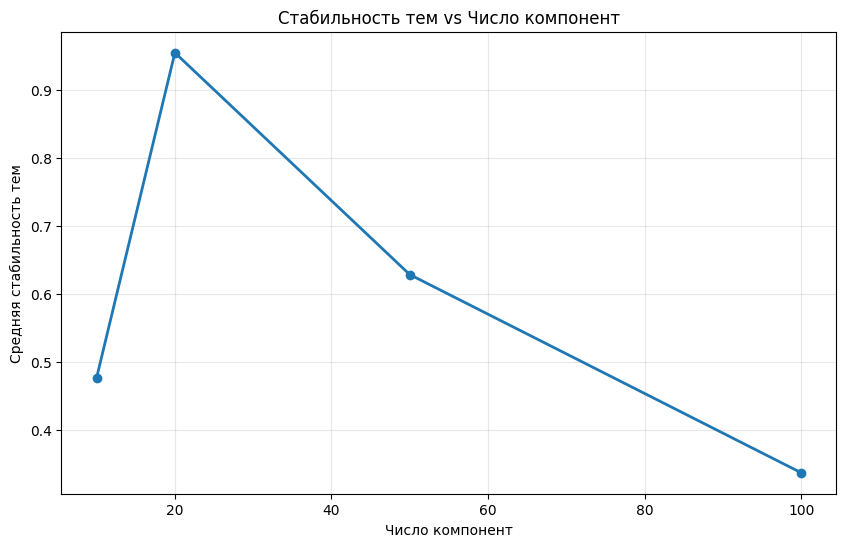

In [ ]:
def analyze_topic_stability(matrix, feature_names, n_components_range=None,
                          n_runs=5, n_top_words=5):
    """
    Анализ стабильности тем при разном числе компонент.
    """
    if n_components_range is None:
        n_components_range = [10, 20, 50, 100]

    stability_results = {}

    print("АНАЛИЗ СТАБИЛЬНОСТИ ТЕМ")
    print("=" * 60)

    for n_comp in n_components_range:
        print(f"\nАнализ для {n_comp} компонент:")

        all_topics_words = []

        for run in range(n_runs):
            svd = TruncatedSVD(n_components=n_comp, random_state=42+run)
            reduced = svd.fit_transform(matrix)

            components = svd.components_
            topics_words = []

            for i in range(n_comp):
                top_indices = components[i].argsort()[-n_top_words:][::-1]
                top_words = [feature_names[j] for j in top_indices]
                topics_words.append(set(top_words))

            all_topics_words.append(topics_words)

        stability_scores = []
        for topic_idx in range(n_comp):
            topic_stability = []
            for i in range(n_runs):
                for j in range(i+1, n_runs):
                    intersection = len(all_topics_words[i][topic_idx] &
                                     all_topics_words[j][topic_idx])
                    union = len(all_topics_words[i][topic_idx] |
                              all_topics_words[j][topic_idx])
                    similarity = intersection / union if union > 0 else 0
                    topic_stability.append(similarity)

            stability_scores.append(np.mean(topic_stability))

        avg_stability = np.mean(stability_scores)
        stability_results[n_comp] = avg_stability

        print(f"Средняя стабильность тем: {avg_stability:.4f}")
        print(f"Минимальная стабильность: {np.min(stability_scores):.4f}")
        print(f"Максимальная стабильность: {np.max(stability_scores):.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(list(stability_results.keys()), list(stability_results.values()),
            marker='o', linewidth=2)
    plt.xlabel('Число компонент')
    plt.ylabel('Средняя стабильность тем')
    plt.title('Стабильность тем vs Число компонент')
    plt.grid(True, alpha=0.3)
    plt.show()

    return stability_results

stability_results = analyze_topic_stability(tfidf_matrix, feature_names)

 ### Этап 4. Сравнительный анализ классических методов векторизации

In [ ]:
import numpy as np
import time
import pandas as pd
from typing import List, Tuple, Dict, Any
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import os


def measure_memory_usage():
    """Измерение использования памяти в МБ."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024


def calculate_semantic_consistency(matrix: sparse.csr_matrix, labels: List[int]) -> float:
    """
    Вычисление семантической согласованности.

    Args:
        matrix: Векторизованная матрица
        labels: Метки классов

    Returns:
        Среднее косинусное сходство внутри классов
    """
    from sklearn.preprocessing import normalize

    if labels is None or len(set(labels)) <= 1:
        return 0.0

    matrix_normalized = normalize(matrix, norm='l2')
    similarities = []
    unique_labels = np.unique(labels)

    for label in unique_labels:
        class_indices = np.where(np.array(labels) == label)[0]
        if len(class_indices) > 1:
            class_similarity = cosine_similarity(matrix_normalized[class_indices])
            triu_indices = np.triu_indices(len(class_indices), k=1)
            class_similarities = class_similarity[triu_indices]
            if len(class_similarities) > 0:
                similarities.extend(class_similarities)

    return np.mean(similarities) if similarities else 0.0


def benchmark_vectorization_method(method_func, texts: List[str],
                                 method_name: str, labels: List[int] = None,
                                 **kwargs) -> Dict[str, Any]:
    """
    Бенчмарк одного метода векторизации.

    Args:
        method_func: Функция векторизации
        texts: Список текстов
        method_name: Название метода
        labels: Метки для семантической согласованности
        **kwargs: Аргументы для метода

    Returns:
        Словарь с метриками
    """
    start_memory = measure_memory_usage()
    start_time = time.time()

    matrix = method_func(texts, **kwargs)

    end_time = time.time()
    end_memory = measure_memory_usage()

    n_documents, n_features = matrix.shape
    sparsity = 1 - (matrix.nnz / (n_documents * n_features))
    processing_time = end_time - start_time
    memory_used = end_memory - start_memory

    semantic_consistency = calculate_semantic_consistency(matrix, labels)

    metrics = {
        'method': method_name,
        'n_features': n_features,
        'n_documents': n_documents,
        'sparsity': sparsity,
        'density': 1 - sparsity,
        'non_zero_elements': matrix.nnz,
        'processing_time_sec': processing_time,
        'memory_usage_mb': memory_used,
        'matrix_size_mb': matrix.data.nbytes / 1024 / 1024,
        'semantic_consistency': semantic_consistency,
        'efficiency_score': calculate_efficiency_score(n_features, processing_time, semantic_consistency)
    }

    return metrics, matrix


def calculate_efficiency_score(n_features: int, processing_time: float,
                             semantic_consistency: float) -> float:
    """
    Расчет комплексного score эффективности.

    Args:
        n_features: Количество признаков
        processing_time: Время обработки
        semantic_consistency: Семантическая согласованность

    Returns:
        Score эффективности (0-1)
    """
    features_score = 1 / (1 + np.log1p(n_features) / 100)
    time_score = 1 / (1 + processing_time * 10)
    consistency_score = semantic_consistency

    return 0.3 * features_score + 0.3 * time_score + 0.4 * consistency_score


def compare_one_hot_methods(texts: List[str], labels: List[int] = None) -> pd.DataFrame:
    """
    Сравнение различных вариантов One-Hot Encoding.

    Returns:
        DataFrame с результатами сравнения
    """
    configurations = [
        {'ngram_range': (1, 1), 'analyzer': 'word', 'name': 'OneHot_Unigrams'},
        {'ngram_range': (1, 2), 'analyzer': 'word', 'name': 'OneHot_UniBigrams'},
        {'ngram_range': (1, 3), 'analyzer': 'word', 'name': 'OneHot_UniBiTrigrams'},
        {'ngram_range': (2, 2), 'analyzer': 'word', 'name': 'OneHot_Bigrams'},
        {'ngram_range': (3, 3), 'analyzer': 'word', 'name': 'OneHot_Trigrams'},
    ]

    results = []
    print("СРАВНЕНИЕ ONE-HOT ENCODING МЕТОДОВ")
    print("=" * 50)

    for config in configurations:
        print(f"Тестирование {config['name']}...")
        metrics, _ = benchmark_vectorization_method(
            one_hot_encoding, texts, config['name'], labels,
            ngram_range=config['ngram_range'], analyzer=config['analyzer']
        )
        results.append(metrics)
        print(f"  Признаков: {metrics['n_features']}, "
              f"Время: {metrics['processing_time_sec']:.4f}с, "
              f"Согласованность: {metrics['semantic_consistency']:.4f}")

    return pd.DataFrame(results)


def compare_bow_methods(texts: List[str], labels: List[int] = None) -> pd.DataFrame:
    """
    Сравнение различных вариантов Bag of Words.

    Returns:
        DataFrame с результатами сравнения
    """
    configurations = [
        {'weighting_scheme': 'count', 'ngram_range': (1, 1), 'name': 'BoW_Count_Unigrams'},
        {'weighting_scheme': 'count', 'ngram_range': (1, 2), 'name': 'BoW_Count_UniBigrams'},
        {'weighting_scheme': 'count', 'ngram_range': (1, 3), 'name': 'BoW_Count_UniBiTrigrams'},
        {'weighting_scheme': 'binary', 'ngram_range': (1, 1), 'name': 'BoW_Binary_Unigrams'},
        {'weighting_scheme': 'binary', 'ngram_range': (1, 2), 'name': 'BoW_Binary_UniBigrams'},
        {'weighting_scheme': 'freq', 'ngram_range': (1, 1), 'name': 'BoW_Freq_Unigrams'},
        {'weighting_scheme': 'freq', 'ngram_range': (1, 2), 'name': 'BoW_Freq_UniBigrams'},
    ]

    results = []
    print("\nСРАВНЕНИЕ BAG OF WORDS МЕТОДОВ")
    print("=" * 50)

    for config in configurations:
        print(f"Тестирование {config['name']}...")
        metrics, _ = benchmark_vectorization_method(
            bag_of_words, texts, config['name'], labels,
            weighting_scheme=config['weighting_scheme'],
            ngram_range=config['ngram_range']
        )
        results.append(metrics)
        print(f"  Признаков: {metrics['n_features']}, "
              f"Время: {metrics['processing_time_sec']:.4f}с, "
              f"Согласованность: {metrics['semantic_consistency']:.4f}")

    return pd.DataFrame(results)


def compare_tfidf_methods(texts: List[str], labels: List[int] = None) -> pd.DataFrame:
    """
    Сравнение различных вариантов TF-IDF.

    Returns:
        DataFrame с результатами сравнения
    """
    configurations = [
        {'ngram_range': (1, 1), 'smooth_idf': True, 'sublinear_tf': False, 'name': 'TFIDF_Basic_Unigrams'},
        {'ngram_range': (1, 2), 'smooth_idf': True, 'sublinear_tf': False, 'name': 'TFIDF_Basic_UniBigrams'},
        {'ngram_range': (1, 3), 'smooth_idf': True, 'sublinear_tf': False, 'name': 'TFIDF_Basic_UniBiTrigrams'},
        {'ngram_range': (1, 1), 'smooth_idf': False, 'sublinear_tf': False, 'name': 'TFIDF_NoSmooth_Unigrams'},
        {'ngram_range': (1, 1), 'smooth_idf': True, 'sublinear_tf': True, 'name': 'TFIDF_Sublinear_Unigrams'},
        {'ngram_range': (1, 1), 'smooth_idf': False, 'sublinear_tf': True, 'name': 'TFIDF_NoSmooth_Sublinear'},
    ]

    results = []
    print("\nСРАВНЕНИЕ TF-IDF МЕТОДОВ")
    print("=" * 50)

    for config in configurations:
        print(f"Тестирование {config['name']}...")
        metrics, _ = benchmark_vectorization_method(
            tfidf_vectorization, texts, config['name'], labels,
            ngram_range=config['ngram_range'],
            smooth_idf=config['smooth_idf'],
            sublinear_tf=config['sublinear_tf']
        )
        results.append(metrics)
        print(f"  Признаков: {metrics['n_features']}, "
              f"Время: {metrics['processing_time_sec']:.4f}с, "
              f"Согласованность: {metrics['semantic_consistency']:.4f}")

    return pd.DataFrame(results)


def comprehensive_comparison(texts: List[str], labels: List[int] = None) -> pd.DataFrame:
    """
    Полное сравнение всех методов векторизации.

    Returns:
        DataFrame с результатами всех сравнений
    """
    print("ПОЛНОЕ СРАВНЕНИЕ МЕТОДОВ ВЕКТОРИЗАЦИИ")
    print("=" * 60)

    onehot_results = compare_one_hot_methods(texts, labels)
    bow_results = compare_bow_methods(texts, labels)
    tfidf_results = compare_tfidf_methods(texts, labels)

    all_results = pd.concat([onehot_results, bow_results, tfidf_results], ignore_index=True)

    all_results = all_results.sort_values('efficiency_score', ascending=False)

    return all_results


def visualize_comparison(results_df: pd.DataFrame, save_path: str = None):
    """
    Визуализация результатов сравнения.

    Args:
        results_df: DataFrame с результатами
        save_path: Путь для сохранения графиков
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    methods = results_df['method']

    # 1. Количество признаков
    axes[0, 0].barh(range(len(methods)), results_df['n_features'], color='skyblue', alpha=0.7)
    axes[0, 0].set_yticks(range(len(methods)))
    axes[0, 0].set_yticklabels(methods)
    axes[0, 0].set_xlabel('Количество признаков')
    axes[0, 0].set_title('Размерность признакового пространства')

    # 2. Разреженность
    axes[0, 1].barh(range(len(methods)), results_df['sparsity'], color='lightcoral', alpha=0.7)
    axes[0, 1].set_yticks(range(len(methods)))
    axes[0, 1].set_yticklabels(methods)
    axes[0, 1].set_xlabel('Доля нулевых элементов')
    axes[0, 1].set_title('Разреженность матриц')

    # 3. Время обработки
    axes[0, 2].barh(range(len(methods)), results_df['processing_time_sec'], color='lightgreen', alpha=0.7)
    axes[0, 2].set_yticks(range(len(methods)))
    axes[0, 2].set_yticklabels(methods)
    axes[0, 2].set_xlabel('Время (секунды)')
    axes[0, 2].set_title('Время обработки')

    # 4. Использование памяти
    axes[1, 0].barh(range(len(methods)), results_df['memory_usage_mb'], color='gold', alpha=0.7)
    axes[1, 0].set_yticks(range(len(methods)))
    axes[1, 0].set_yticklabels(methods)
    axes[1, 0].set_xlabel('Память (МБ)')
    axes[1, 0].set_title('Использование памяти')

    # 5. Семантическая согласованность
    axes[1, 1].barh(range(len(methods)), results_df['semantic_consistency'], color='orange', alpha=0.7)
    axes[1, 1].set_yticks(range(len(methods)))
    axes[1, 1].set_yticklabels(methods)
    axes[1, 1].set_xlabel('Косинусное сходство')
    axes[1, 1].set_title('Семантическая согласованность')

    # 6. Efficiency Score
    axes[1, 2].barh(range(len(methods)), results_df['efficiency_score'], color='purple', alpha=0.7)
    axes[1, 2].set_yticks(range(len(methods)))
    axes[1, 2].set_yticklabels(methods)
    axes[1, 2].set_xlabel('Score')
    axes[1, 2].set_title('Общий Score эффективности')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


def generate_comparison_report(results_df: pd.DataFrame) -> str:
    """
    Генерация текстового отчета по сравнению.

    Args:
        results_df: DataFrame с результатами

    Returns:
        Текстовый отчет
    """
    report = []
    report.append("=" * 80)
    report.append("ОТЧЕТ ПО СРАВНЕНИЮ МЕТОДОВ ВЕКТОРИЗАЦИИ")
    report.append("=" * 80)

    # Топ-3 метода по efficiency score
    top_methods = results_df.head(3)

    report.append("\n🏆 ТОП-3 МЕТОДА ПО ЭФФЕКТИВНОСТИ:")
    report.append("-" * 50)

    for i, (_, method) in enumerate(top_methods.iterrows(), 1):
        report.append(f"{i}. {method['method']}")
        report.append(f"   Score: {method['efficiency_score']:.4f}")
        report.append(f"   Признаков: {method['n_features']}")
        report.append(f"   Время: {method['processing_time_sec']:.4f}с")
        report.append(f"   Согласованность: {method['semantic_consistency']:.4f}")
        report.append(f"   Разреженность: {method['sparsity']:.4f}")
        report.append("")

    # Лучшие по категориям
    report.append("\n🎯 ЛУЧШИЕ МЕТОДЫ ПО КАТЕГОРИЯМ:")
    report.append("-" * 40)

    min_features = results_df.loc[results_df['n_features'].idxmin()]
    report.append(f"Минимальная размерность: {min_features['method']} ({min_features['n_features']} признаков)")

    max_consistency = results_df.loc[results_df['semantic_consistency'].idxmax()]
    report.append(f"Максимальная согласованность: {max_consistency['method']} ({max_consistency['semantic_consistency']:.4f})")

    min_time = results_df.loc[results_df['processing_time_sec'].idxmin()]
    report.append(f"Минимальное время: {min_time['method']} ({min_time['processing_time_sec']:.4f}с)")

    min_memory = results_df.loc[results_df['memory_usage_mb'].idxmin()]
    report.append(f"Минимальная память: {min_memory['method']} ({min_memory['memory_usage_mb']:.2f} МБ)")

    return "\n".join(report)


def run_complete_comparison(texts: List[str], labels: List[int] = None,
                          save_plot: str = None) -> Tuple[pd.DataFrame, str]:
    """
    Запуск полного сравнения методов векторизации.

    Args:
        texts: Список текстов
        labels: Метки классов
        save_plot: Путь для сохранения графиков

    Returns:
        (DataFrame с результатами, текстовый отчет)
    """
    results_df = comprehensive_comparison(texts, labels)

    visualize_comparison(results_df, save_plot)

    report = generate_comparison_report(results_df)

    return results_df, report

ПОЛНОЕ СРАВНЕНИЕ МЕТОДОВ ВЕКТОРИЗАЦИИ
СРАВНЕНИЕ ONE-HOT ENCODING МЕТОДОВ
Тестирование OneHot_Unigrams...
One-Hot Encoding (n-grams (1, 1)):
  Создано признаков: 2251
  Разреженность: 0.9484 (94.84%)
  Плотность: 0.0516 (5.16%)
  Эффективность хранения: 0.0516

  Признаков: 2251, Время: 0.1428с, Согласованность: 0.1891
Тестирование OneHot_UniBigrams...
One-Hot Encoding (n-grams (1, 2)):
  Создано признаков: 6164
  Разреженность: 0.9587 (95.87%)
  Плотность: 0.0413 (4.13%)
  Эффективность хранения: 0.0413

  Признаков: 6164, Время: 0.2496с, Согласованность: 0.1495
Тестирование OneHot_UniBiTrigrams...
One-Hot Encoding (n-grams (1, 3)):
  Создано признаков: 10365
  Разреженность: 0.9617 (96.17%)
  Плотность: 0.0383 (3.83%)
  Эффективность хранения: 0.0383

  Признаков: 10365, Время: 0.3684с, Согласованность: 0.1352
Тестирование OneHot_Bigrams...
One-Hot Encoding (n-grams (2, 2)):
  Создано признаков: 3913
  Разреженность: 0.9646 (96.46%)
  Плотность: 0.0354 (3.54%)
  Эффективность хранения

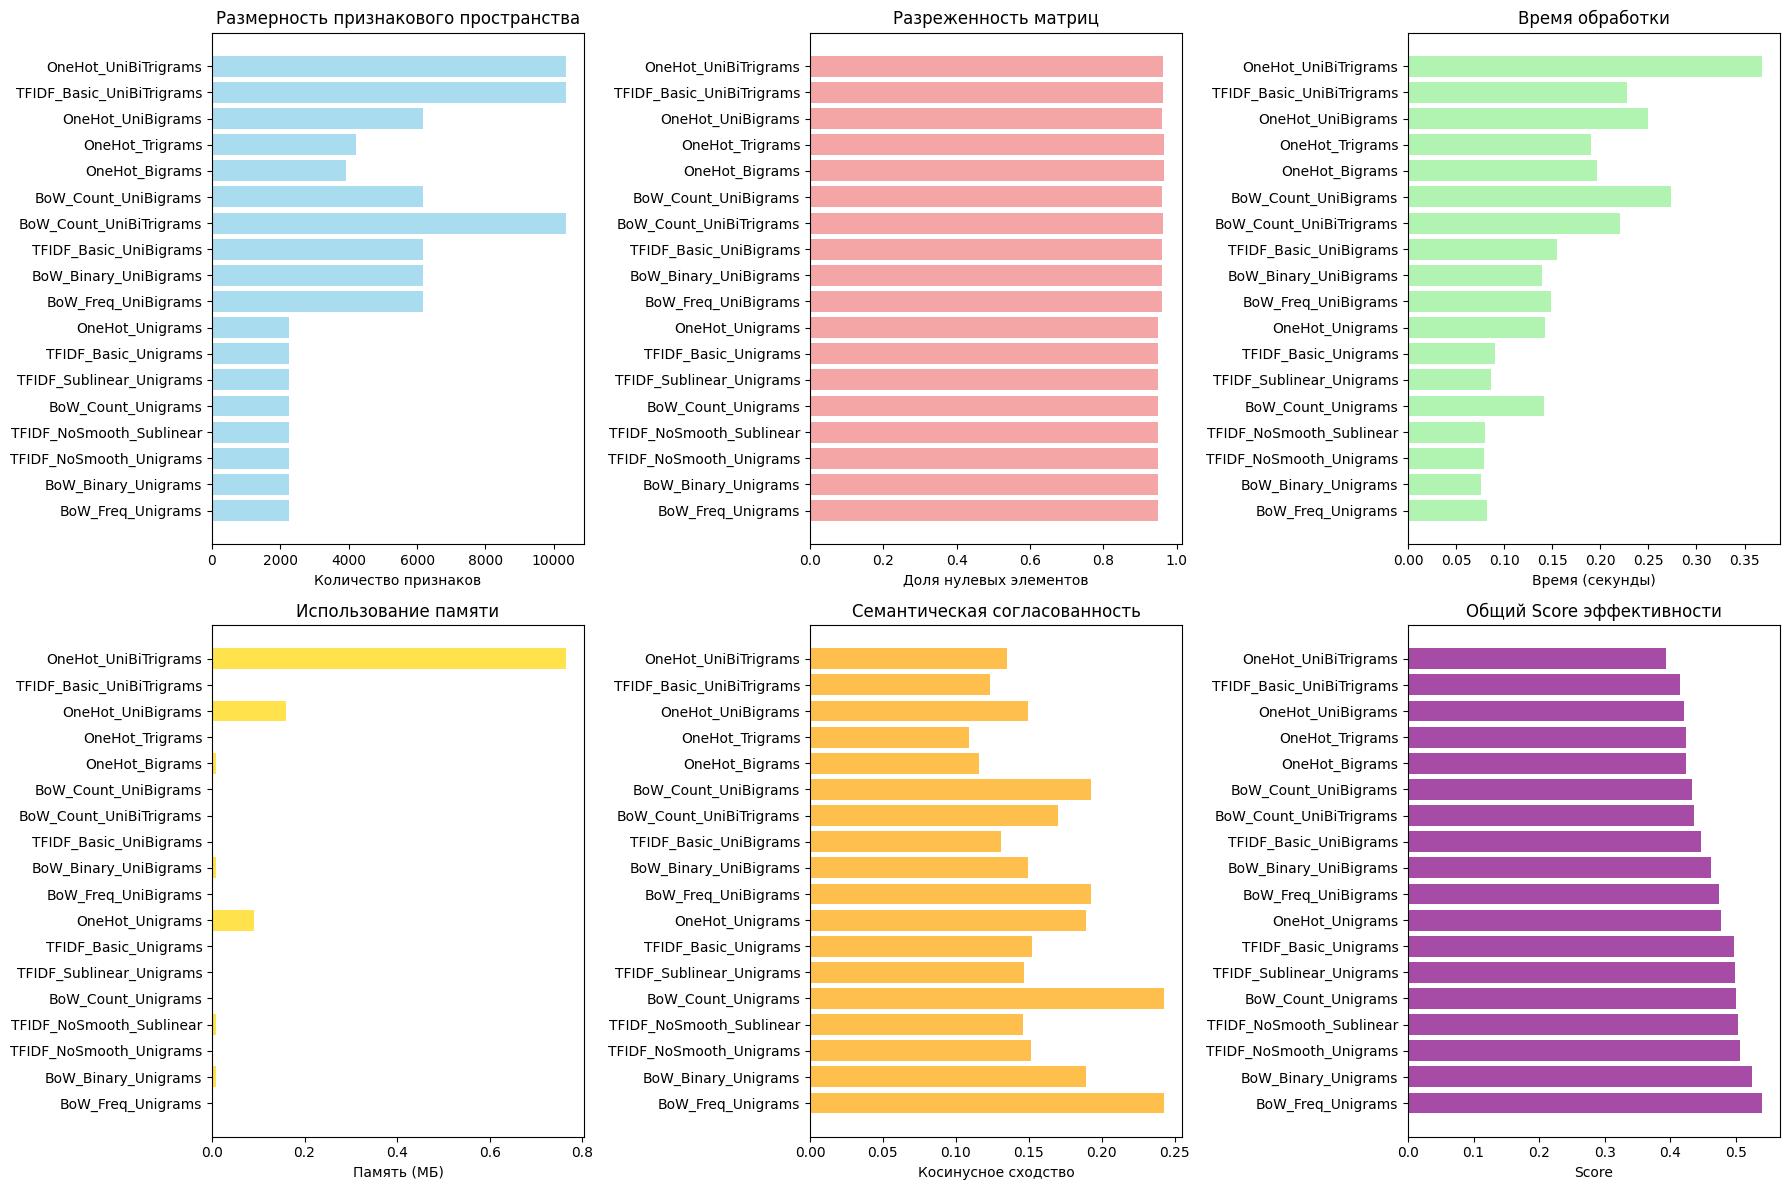

ОТЧЕТ ПО СРАВНЕНИЮ МЕТОДОВ ВЕКТОРИЗАЦИИ

🏆 ТОП-3 МЕТОДА ПО ЭФФЕКТИВНОСТИ:
--------------------------------------------------
1. BoW_Freq_Unigrams
   Score: 0.5403
   Признаков: 2251
   Время: 0.0822с
   Согласованность: 0.2428
   Разреженность: 0.9484

2. BoW_Binary_Unigrams
   Score: 0.5248
   Признаков: 2251
   Время: 0.0758с
   Согласованность: 0.1891
   Разреженность: 0.9484

3. TFIDF_NoSmooth_Unigrams
   Score: 0.5062
   Признаков: 2251
   Время: 0.0795с
   Согласованность: 0.1516
   Разреженность: 0.9484


🎯 ЛУЧШИЕ МЕТОДЫ ПО КАТЕГОРИЯМ:
----------------------------------------
Минимальная размерность: BoW_Freq_Unigrams (2251 признаков)
Максимальная согласованность: BoW_Freq_Unigrams (0.2428)
Минимальное время: BoW_Binary_Unigrams (0.0758с)
Минимальная память: BoW_Freq_Unigrams (0.00 МБ)


In [ ]:
texts_list = [item['text'] for item in all_news]
labels = [item['rubric'] for item in all_news]
results, report = run_complete_comparison(texts_list, labels)
print(report)

#### Этап 5. Обучение моделей распределённых представлений

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 72.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import time
import pandas as pd
from typing import List, Dict, Any, Tuple, Optional
import logging
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.model_selection import train_test_split
import psutil
import os

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def measure_memory_usage():
    """Измерение использования памяти в МБ."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def preprocess_corpus(texts: List[str]) -> List[List[str]]:
    """
    Предобработка корпуса для обучения моделей.

    Args:
        texts: Список текстов

    Returns:
        Токенизированные тексты
    """
    processed_texts = []
    for text in texts:
        # Базовая предобработка
        if isinstance(text, str):
            tokens = text.lower().split()
            processed_texts.append(tokens)
        else:
            processed_texts.append([])

    logger.info(f"Предобработано {len(processed_texts)} документов")
    return processed_texts

def train_word2vec(corpus: List[List[str]], vector_size: int = 100,
                  window: int = 5, min_count: int = 5, sg: int = 0,
                  workers: int = 4, epochs: int = 5, save_path: str = None) -> Tuple[Any, Dict[str, Any]]:
    """
    Обучение Word2Vec модели.

    Args:
        corpus: Токенизированный корпус
        vector_size: Размерность векторов
        window: Размер окна контекста
        min_count: Минимальная частота слова
        sg: Архитектура (0=CBOW, 1=Skip-gram)
        workers: Количество потоков
        epochs: Количество эпох
        save_path: Путь для сохранения модели

    Returns:
        (модель, метрики обучения)
    """
    from gensim.models import Word2Vec

    architecture = "CBOW" if sg == 0 else "Skip-gram"
    logger.info(f"Обучение Word2Vec ({architecture}), size={vector_size}, window={window}")

    start_time = time.time()
    start_memory = measure_memory_usage()

    model = Word2Vec(
        sentences=corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        workers=workers,
        epochs=epochs
    )

    end_time = time.time()
    end_memory = measure_memory_usage()

    # Сохранение модели
    if save_path:
        model.save(save_path)
        logger.info(f"✅ Модель сохранена: {save_path}")

    metrics = {
        'model_type': f'Word2Vec_{architecture}',
        'vector_size': vector_size,
        'window': window,
        'vocab_size': len(model.wv.key_to_index),
        'training_time_sec': end_time - start_time,
        'memory_usage_mb': end_memory - start_memory,
        'epochs': epochs,
        'save_path': save_path
    }

    return model, metrics

def train_fasttext_gensim(corpus: List[List[str]], vector_size: int = 100,
                         window: int = 5, min_count: int = 5, sg: int = 0,
                         workers: int = 4, epochs: int = 5) -> Tuple[Any, Dict[str, Any]]:
    """
    Обучение FastText модели через gensim.

    Args:
        corpus: Токенизированный корпус
        vector_size: Размерность векторов
        window: Размер окна контекста
        min_count: Минимальная частота слова
        sg: Архитектура (0=CBOW, 1=Skip-gram)
        workers: Количество потоков
        epochs: Количество эпох

    Returns:
        (модель, метрики обучения)
    """
    from gensim.models import FastText

    architecture = "CBOW" if sg == 0 else "Skip-gram"
    logger.info(f"Обучение FastText ({architecture}), size={vector_size}, window={window}")

    start_time = time.time()
    start_memory = measure_memory_usage()

    model = FastText(
        sentences=corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        workers=workers,
        epochs=epochs
    )

    end_time = time.time()
    end_memory = measure_memory_usage()

    metrics = {
        'model_type': f'FastText_{architecture}',
        'vector_size': vector_size,
        'window': window,
        'vocab_size': len(model.wv.key_to_index),
        'training_time_sec': end_time - start_time,
        'memory_usage_mb': end_memory - start_memory,
        'epochs': epochs
    }

    return model, metrics

def train_doc2vec(corpus: List[List[str]], labels: List[str] = None,
                 vector_size: int = 100, window: int = 5, min_count: int = 5,
                 dm: int = 1, workers: int = 4, epochs: int = 5) -> Tuple[Any, Dict[str, Any]]:
    """
    Обучение Doc2Vec модели.

    Args:
        corpus: Токенизированный корпус
        labels: Метки документов (для tagged documents)
        vector_size: Размерность векторов
        window: Размер окна контекста
        min_count: Минимальная частота слова
        dm: Архитектура (1=PV-DM, 0=PV-DBOW)
        workers: Количество потоков
        epochs: Количество эпох

    Returns:
        (модель, метрики обучения)
    """
    from gensim.models import Doc2Vec
    from gensim.models.doc2vec import TaggedDocument

    architecture = "PV-DM" if dm == 1 else "PV-DBOW"
    logger.info(f"Обучение Doc2Vec ({architecture}), size={vector_size}, window={window}")

    # Создаем tagged documents
    if labels is None:
        tags = [f"doc_{i}" for i in range(len(corpus))]
    else:
        # Преобразуем метки в строки и создаем уникальные теги
        tags = [f"{label}_{i}" for i, label in enumerate(labels)]

    tagged_corpus = [TaggedDocument(words=doc, tags=[tag])
                    for doc, tag in zip(corpus, tags)]

    start_time = time.time()
    start_memory = measure_memory_usage()

    model = Doc2Vec(
        documents=tagged_corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        dm=dm,
        workers=workers,
        epochs=epochs
    )

    end_time = time.time()
    end_memory = measure_memory_usage()

    metrics = {
        'model_type': f'Doc2Vec_{architecture}',
        'vector_size': vector_size,
        'window': window,
        'vocab_size': len(model.wv.key_to_index),
        'doc_vectors': len(model.dv.key_to_index),
        'training_time_sec': end_time - start_time,
        'memory_usage_mb': end_memory - start_memory,
        'epochs': epochs
    }

    return model, metrics

def get_document_vectors(model, corpus: List[List[str]], labels: List[str] = None) -> np.ndarray:
    """
    Получение векторов документов из Doc2Vec модели.

    Args:
        model: Обученная Doc2Vec модель
        corpus: Токенизированный корпус
        labels: Метки документов (должны соответствовать тегам в модели)

    Returns:
        Матрица векторов документов
    """
    if labels is None:
        doc_tags = [f"doc_{i}" for i in range(len(corpus))]
    else:
        doc_tags = [f"{label}_{i}" for i, label in enumerate(labels)]

    doc_vectors = []
    valid_indices = []

    for i, tag in enumerate(doc_tags):
        if tag in model.dv:
            doc_vectors.append(model.dv[tag])
            valid_indices.append(i)

    logger.info(f"Получено {len(doc_vectors)} векторов документов из {len(corpus)}")
    return np.array(doc_vectors), valid_indices

def evaluate_word_analogy(model, analogy_file: str = None) -> float:
    """
    Оценка качества word embeddings через аналогии.
    """
    try:
        if analogy_file and os.path.exists(analogy_file):
            accuracy = model.wv.evaluate_word_analogies(analogy_file)[0]
        else:
            # Базовый тест на аналогиях
            analogies = [
                # Столицы и страны
                ['казан', 'татарстан', 'россия', 'мәскәү'],
                ['мәскәү', 'россия', 'германия', 'берлин'],
                ['анкара', 'төркия', 'франция', 'париж'],

                # Валюта
                ['сум', 'үзбәкстан', 'казахстан', 'тенге'],
                ['тенге', 'казахстан', 'россия', 'рубль'],
                ['рубль', 'россия', 'америка', 'доллар'],

                ['гадәттән', 'тыш', 'гамәлдән', 'чыгарылды'],

                # Руководители
                ['миннеханов', 'татарстан', 'россия', 'путин'],
                ['путин', 'россия', 'төркия', 'эрдоган'],

                # Города и регионы
                ['яшел ҫүз', 'яшел ҫүз', 'казан', 'казан'],  # район-город
                ['чаллы', 'татарстан', 'россия', 'мәскәү'],

                # Суффиксы
                ['укы', 'укытучы', 'яса', 'ясаучы'],   # профессия
                ['уйла', 'уйлану', 'яса', 'ясалу'],     # рефлексивность
                ['якшы', 'якшырак', 'яман', 'яманрак'], # сравнительная степень

                # Прилагательные
                ['зур', 'зуррак', 'кече', 'кечерәк'],
                ['якшы', 'якшылык', 'яман', 'яманлык'], # образование существительных
            ]

            analogies = [
                          ['матбугат', 'хезмәте', 'диде', 'ул.'],
                          ['хезмәте', 'хәбәр', 'махсус', 'хәрби'],
                          ['эчке', 'эшләр', 'татарстан', 'республикасы'],
                          ['хәбәр', 'итә.', 'сум', 'тәшкил'],
                          ['хокук', 'саклау', 'тәэмин', 'итү'],
                          ['алексей', 'песошин', '«шаян', 'тв»'],
                          ['«шаян', 'шортс»', 'ясалма', 'фәһем'],
                          ['аның', 'сүзләренчә,', 'татар', 'дәүләт'],
                          ['төп', 'ставканы', '«ватанны', 'саклаучылар»'],
                          ['бүгенге', 'көндә', 'россия', 'гадәттән'],
                          ['гадәттән', 'тыш', 'тыш', 'хәлләр'],
                          ['хәлләр', 'министрлыгының', 'премьер-министры', 'алексей'],
                          ['суд', 'приставлары', 'приставлары', 'федераль'],
                          ['федераль', 'хезмәте', 'республикасы', 'милли'],
                          ['хәрби', 'операциядә', 'хәрби', 'операция'],
                          ['милли', 'музее', 'түләүнең', 'минималь'],
                          ['хезмәт', 'хакы', 'кабул', 'итү'],
                          ['«татарстан', 'гасыр»', 'гасыр»', 'телерадиокомпаниясенең'],
                          ['телерадиокомпаниясенең', '«шаян', 'яңалыклар', 'программасын'],
                          ['тәкъдим', 'итү', 'дәүләт', 'советы']
                         ]

            correct = 0
            total = 0

            for analogy in analogies:
                try:
                    predicted = model.wv.most_similar(positive=[analogy[1], analogy[2]],
                                                    negative=[analogy[0]], topn=1)[0][0]
                    if predicted == analogy[3]:
                        correct += 1
                    total += 1
                except:
                    continue

            accuracy = correct / total if total > 0 else 0.0

        return accuracy
    except Exception as e:
        logger.warning(f"Ошибка в оценке аналогий: {e}")
        return 0.0

def evaluate_semantic_similarity(model, word_pairs: List[Tuple[str, str, float]] = None) -> float:
    """
    Оценка корреляции с человеческими оценками семантического сходства.
    """
    if word_pairs is None:
        word_pairs = [
            ('компьютер', 'ноутбук', 0.8),
            ('машина', 'автомобиль', 0.9),
            ('дом', 'здание', 0.7),
        ]

    from scipy.stats import pearsonr

    model_scores = []
    human_scores = []

    for word1, word2, human_score in word_pairs:
        try:
            similarity = model.wv.similarity(word1, word2)
            model_scores.append(similarity)
            human_scores.append(human_score)
        except KeyError:
            continue

    if len(model_scores) > 1:
        correlation, _ = pearsonr(model_scores, human_scores)
        return correlation
    else:
        return 0.0

def evaluate_oov_coverage(model, test_words: List[str] = None) -> float:
    """
    Оценка покрытия словаря (доля OOV слов).
    """
    if test_words is None:
        test_words = list(model.wv.key_to_index.keys())[:1000]

    known_words = 0
    for word in test_words:
        if word in model.wv:
            known_words += 1

    coverage = known_words / len(test_words) if test_words else 0.0
    return coverage

def evaluate_document_clustering(doc_vectors: np.ndarray, true_labels: List[int]) -> float:
    """
    Оценка качества кластеризации документов.
    """
    if len(set(true_labels)) <= 1 or len(doc_vectors) == 0:
        return 0.0

    # Выбираем только те документы, для которых есть векторы
    if len(doc_vectors) != len(true_labels):
        logger.warning(f"Размеры не совпадают: vectors={len(doc_vectors)}, labels={len(true_labels)}")
        return 0.0

    kmeans = KMeans(n_clusters=len(set(true_labels)), random_state=42)
    predicted_labels = kmeans.fit_predict(doc_vectors)

    ari = adjusted_rand_score(true_labels, predicted_labels)
    return ari

def evaluate_document_classification(doc_vectors: np.ndarray, labels: List[int],
                                   test_size: float = 0.3) -> float:
    """
    Оценка точности классификации документов.
    """
    if len(set(labels)) <= 1 or len(doc_vectors) == 0:
        return 0.0

    # Проверяем соответствие размеров
    if len(doc_vectors) != len(labels):
        logger.warning(f"Размеры не совпадают: vectors={len(doc_vectors)}, labels={len(labels)}")
        return 0.0

    X_train, X_test, y_train, y_test = train_test_split(
        doc_vectors, labels, test_size=test_size, random_state=42, stratify=labels
    )

    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def train_all_models(corpus: List[List[str]], labels: List[int] = None,
                    vector_sizes: List[int] = None, windows: List[int] = None,
                    min_count: int = 5, epochs: int = 5) -> pd.DataFrame:
    """
    Обучение всех моделей с разными параметрами.
    """
    if vector_sizes is None:
        vector_sizes = [100, 200]
    if windows is None:
        windows = [5, 8]

    all_results = []

    logger.info("Начало обучения всех моделей...")

    # Word2Vec
    for vector_size in vector_sizes:
        for window in windows:
            for sg in [0, 1]:
                try:
                    logger.info(f"Обучение Word2Vec: size={vector_size}, window={window}, sg={sg}")
                    model, metrics = train_word2vec(
                        corpus, vector_size=vector_size, window=window,
                        min_count=min_count, sg=sg, epochs=epochs
                    )

                    # Оценка качества word embeddings
                    analogy_accuracy = evaluate_word_analogy(model)
                    semantic_correlation = evaluate_semantic_similarity(model)
                    coverage = evaluate_oov_coverage(model)

                    results = {
                        **metrics,
                        'analogy_accuracy': analogy_accuracy,
                        'semantic_correlation': semantic_correlation,
                        'vocab_coverage': coverage
                    }
                    all_results.append(results)
                    logger.info(f"Word2Vec завершен: accuracy={analogy_accuracy:.4f}")

                except Exception as e:
                    logger.error(f"Ошибка в Word2Vec: {e}")

    # FastText
    for vector_size in vector_sizes:
        for window in windows:
            for sg in [0, 1]:
                try:
                    logger.info(f"Обучение FastText: size={vector_size}, window={window}, sg={sg}")
                    model, metrics = train_fasttext_gensim(
                        corpus, vector_size=vector_size, window=window,
                        min_count=min_count, sg=sg, epochs=epochs
                    )

                    analogy_accuracy = evaluate_word_analogy(model)
                    semantic_correlation = evaluate_semantic_similarity(model)
                    coverage = evaluate_oov_coverage(model)

                    results = {
                        **metrics,
                        'analogy_accuracy': analogy_accuracy,
                        'semantic_correlation': semantic_correlation,
                        'vocab_coverage': coverage
                    }
                    all_results.append(results)
                    logger.info(f"FastText завершен: accuracy={analogy_accuracy:.4f}")

                except Exception as e:
                    logger.error(f"Ошибка в FastText: {e}")

    # Doc2Vec (только если есть labels и достаточно данных)
    if labels is not None and len(corpus) > 10:
        # Преобразуем числовые метки в строки для Doc2Vec
        unique_labels = list(set(labels))
        if len(unique_labels) > 1:  # Нужно как минимум 2 класса
            for vector_size in vector_sizes:
                for window in windows:
                    for dm in [0, 1]:
                        try:
                            logger.info(f"Обучение Doc2Vec: size={vector_size}, window={window}, dm={dm}")
                            model, metrics = train_doc2vec(
                                corpus, labels=labels, vector_size=vector_size,
                                window=window, min_count=min_count, dm=dm, epochs=epochs
                            )

                            # Получаем векторы документов
                            doc_vectors, valid_indices = get_document_vectors(model, corpus, labels)

                            if len(doc_vectors) > 0:
                                # Фильтруем метки для соответствующих документов
                                filtered_labels = [labels[i] for i in valid_indices]

                                # Оценка качества
                                clustering_score = evaluate_document_clustering(doc_vectors, filtered_labels)
                                classification_accuracy = evaluate_document_classification(doc_vectors, filtered_labels)

                                results = {
                                    **metrics,
                                    'clustering_ari': clustering_score,
                                    'classification_accuracy': classification_accuracy,
                                    'doc_vectors_obtained': len(doc_vectors)
                                }
                                all_results.append(results)
                                logger.info(f"Doc2Vec завершен: clustering={clustering_score:.4f}, classification={classification_accuracy:.4f}")
                            else:
                                logger.warning("Не удалось получить векторы документов для Doc2Vec")

                        except Exception as e:
                            logger.error(f"Ошибка в Doc2Vec: {e}")
        else:
            logger.warning("Слишком мало уникальных меток для Doc2Vec")
    else:
        logger.info("Пропуск Doc2Vec: нет labels или недостаточно данных")

    return pd.DataFrame(all_results)

def visualize_training_results(results_df: pd.DataFrame, save_path: str = None):
    """
    Визуализация результатов обучения моделей.
    """
    if results_df.empty:
        logger.warning("Нет данных для визуализации")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Время обучения по типам моделей
    if 'training_time_sec' in results_df.columns:
        model_times = results_df.groupby('model_type')['training_time_sec'].mean()
        axes[0, 0].bar(model_times.index, model_times.values, color='skyblue')
        axes[0, 0].set_title('Среднее время обучения')
        axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Accuracy аналогий
    if 'analogy_accuracy' in results_df.columns:
        analogy_acc = results_df.groupby('model_type')['analogy_accuracy'].mean()
        axes[0, 1].bar(analogy_acc.index, analogy_acc.values, color='lightgreen')
        axes[0, 1].set_title('Средняя accuracy аналогий')
        axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Размер словаря
    if 'vocab_size' in results_df.columns:
        vocab_sizes = results_df.groupby('model_type')['vocab_size'].mean()
        axes[1, 0].bar(vocab_sizes.index, vocab_sizes.values, color='lightcoral')
        axes[1, 0].set_title('Средний размер словаря')
        axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Classification accuracy (если есть)
    if 'classification_accuracy' in results_df.columns:
        classification_data = results_df[results_df['classification_accuracy'].notna()]
        if not classification_data.empty:
            class_acc = classification_data.groupby('model_type')['classification_accuracy'].mean()
            axes[1, 1].bar(class_acc.index, class_acc.values, color='gold')
            axes[1, 1].set_title('Средняя accuracy классификации')
            axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


def run_complete_training(texts: List[str], labels: List[int] = None,
                         vector_sizes: List[int] = None, windows: List[int] = None,
                         min_count: int = 5, epochs: int = 5) -> Tuple[pd.DataFrame, str]:
    """
    Полный pipeline обучения и оценки моделей.
    """
    corpus = preprocess_corpus(texts)

    results_df = train_all_models(
        corpus, labels=labels, vector_sizes=vector_sizes,
        windows=windows, min_count=min_count, epochs=epochs
    )

    visualize_training_results(results_df)

    return results_df, report

In [ ]:
def remove_stopwords(corpus):
    """Удаление служебных слов из корпуса"""
    tatar_stopwords = {
        'һәм', 'бу', 'белән', 'дип', 'өчен',
        'ук', 'буенча', 'шулай', 'итә',
        'тр', 'булды', 'ул', 'дә', 'билгеләп', 'соң',
        '–', 'әле', 'инде', 'генә', 'гына', 'мыни',
        'әллә', 'бит', 'икән', 'иде', 'икән', 'имеш', 'кенә',
        'тә', 'түгел', 'чак', 'шыл', 'гына', 'мыни', 'ә', 'бары',
        'барлык', 'барча', 'берни', 'бернинди', 'бөтен', 'бөтенесе',
        'гына', 'дә', 'затлы', 'икенче', 'кайбер', 'күбесенчә', 'күп',
        'күпме', 'күпмегә', 'күпмедер', 'күпмелек', 'күрә',
        'менә', 'нәрсә', 'нәрсәдер', 'нәрсәне', 'нәрсәнең', 'нәрсәгә',
        'нәрсәдән', 'нәрсәне', 'нәрсәләр', 'нәрсәләрне', 'нәрсәләрнең',
        'нәрсәләргә', 'нәрсәләрдән', 'ни', 'нигә', 'ничек', 'ниндә',
        'нисә', 'нисәгә', 'нисәдән', 'нисәне', 'нисәнең', 'никадәр',
        'никадер', 'ником', 'ничек', 'ничә', 'ничәгә', 'ничәдән',
        'ничәне', 'ничәнең', 'ния', 'ниядән', 'нияне', 'ниянең', 'шул', 'шулай',
        'шуның', 'шуңа', 'шуңарга', 'яки', 'яман', 'яңа'
    }

    filtered_texts = []
    for text in texts_list:
        if isinstance(text, str):
            words = text.lower().split()
            filtered_words = [word for word in words if word not in tatar_stopwords and len(word) > 2]
            filtered_texts.append(' '.join(filtered_words))
        else:
            filtered_texts.append('')

    return filtered_texts

In [ ]:
filtered_corpus = remove_stopwords(texts_list)

In [ ]:
filtered_corpus[1]

'татарстанда 22.17 сәгатьтә «пилотсыз куркыны» режимы гамәлдән чыгарылды. хакта мәгълүмат россия гадәттән тыш хәлләр министрлыгының рәсми кушымтасында чыкты. исегезгә төшерәбез, режимны бер сәгать элек, мәскәү вакыты 21.14 сәгатьтә керткәннәр иде.'

In [ ]:
def analyze_corpus_for_relations(texts_list):
    """Анализируем, какие отношения ЕСТЬ в корпусе"""

    from collections import Counter

    bigrams = []
    for text in texts_list:
        words = text.lower().split()
        for i in range(len(words)-1):
            bigrams.append((words[i], words[i+1]))

    common_pairs = Counter(bigrams).most_common(50)

    print("📊 ТОП-40 пар слов из корпуса:")
    for (w1, w2), count in common_pairs[:10]:
        print(f"  {w1} - {w2}: {count}")

    return common_pairs

common_pairs = analyze_corpus_for_relations(filtered_corpus)

📊 ТОП-40 пар слов из корпуса:
  матбугат - хезмәте: 140
  диде - ул.: 120
  хезмәте - хәбәр: 120
  махсус - хәрби: 120
  эчке - эшләр: 120
  татарстан - республикасы: 100
  хәбәр - итә.: 100
  сум - тәшкил: 100
  хокук - саклау: 100
  тәэмин - итү: 100


Всего документов: 600
Уникальные рубрики: 7
Распределение: {'Җәмгыять': 300, 'Мәдәният': 100, 'Хәвеф-хәтәр': 80, 'Сәясәт': 40, 'Икътисад': 40, 'Татар дөньясы': 20, 'Махсус хәрби операция': 20}


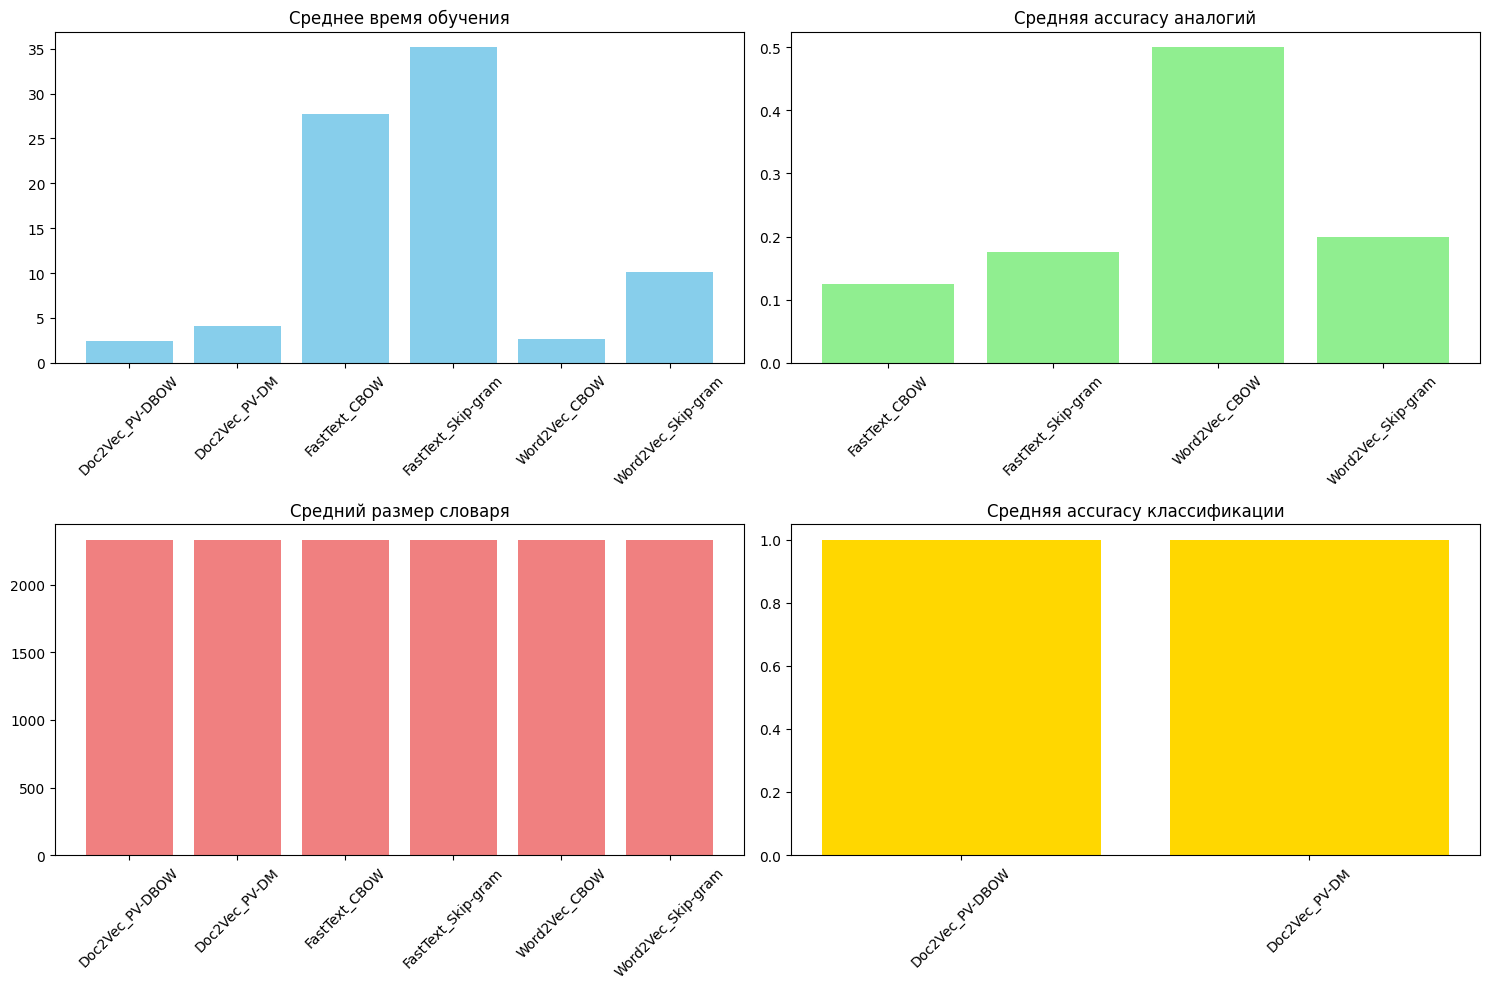

ОТЧЕТ ПО СРАВНЕНИЮ МЕТОДОВ ВЕКТОРИЗАЦИИ

🏆 ТОП-3 МЕТОДА ПО ЭФФЕКТИВНОСТИ:
--------------------------------------------------
1. BoW_Freq_Unigrams
   Score: 0.5403
   Признаков: 2251
   Время: 0.0822с
   Согласованность: 0.2428
   Разреженность: 0.9484

2. BoW_Binary_Unigrams
   Score: 0.5248
   Признаков: 2251
   Время: 0.0758с
   Согласованность: 0.1891
   Разреженность: 0.9484

3. TFIDF_NoSmooth_Unigrams
   Score: 0.5062
   Признаков: 2251
   Время: 0.0795с
   Согласованность: 0.1516
   Разреженность: 0.9484


🎯 ЛУЧШИЕ МЕТОДЫ ПО КАТЕГОРИЯМ:
----------------------------------------
Минимальная размерность: BoW_Freq_Unigrams (2251 признаков)
Максимальная согласованность: BoW_Freq_Unigrams (0.2428)
Минимальное время: BoW_Binary_Unigrams (0.0758с)
Минимальная память: BoW_Freq_Unigrams (0.00 МБ)


In [ ]:
texts_list = [item['text'] for item in all_news]
labels = [item['rubric'] for item in all_news]

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

print(f"Всего документов: {len(texts_list)}")
print(f"Уникальные рубрики: {len(set(labels))}")
print(f"Распределение: {pd.Series(labels).value_counts().to_dict()}")

results, report = run_complete_training(
    filtered_corpus, numeric_labels,
    vector_sizes=[100, 200],
    windows=[5, 8],
    min_count=1,
    epochs=20
)

print(report)

6.1. Косинусное расстояние и семантическое сходство:

- Реализовать вычисление косинусного сходства между векторами


- Проанализировать распределение расстояний в пространстве


- Построить матрицы семантической близости для тестовых слов


- Оценить сходство для пар синонимов, антонимов, тематически близких слов

In [ ]:
def compute_pairwise_similarities(model, word_pairs):
    """
    6.1.1 Вычисление косинусного сходства между векторами
    """
    print("=== 6.1.1 ВЫЧИСЛЕНИЕ КОСИНУСНОГО СХОДСТВА ===")

    wv = model.wv
    results = []
    valid_pairs = []

    for word1, word2 in word_pairs:
        if word1 in wv and word2 in wv:
            similarity = wv.similarity(word1, word2)
            results.append({
                'word1': word1,
                'word2': word2,
                'similarity': similarity
            })
            valid_pairs.append((word1, word2, similarity))
        else:
            missing = []
            if word1 not in wv:
                missing.append(word1)
            if word2 not in wv:
                missing.append(word2)
            print(f"❌ Пропущены слова: {missing}")

    df = pd.DataFrame(results)

    if not df.empty:
        print(f"Обработано пар: {len(df)}")
        print(f"Среднее сходство: {df['similarity'].mean():.3f}")
        print(f"Максимальное сходство: {df['similarity'].max():.3f}")
        print(f"Минимальное сходство: {df['similarity'].min():.3f}")

        top_pairs = df.nlargest(5, 'similarity')
        print("\nТоп-5 самых близких пар:")
        for _, row in top_pairs.iterrows():
            print(f"  {row['word1']} - {row['word2']}: {row['similarity']:.3f}")

    return df, valid_pairs

def analyze_distance_distribution(model, test_words, num_samples=1000):
    """
    6.1.2 Анализ распределения расстояний в пространстве
    """
    print("\n=== 6.1.2 АНАЛИЗ РАСПРЕДЕЛЕНИЯ РАССТАНОВИЙ ===")

    wv = model.wv
    available_words = [word for word in test_words if word in wv]

    if len(available_words) < 2:
        print("Недостаточно слов для анализа")
        return None

    similarities = []

    np.random.seed(42)
    for _ in range(num_samples):
        word1, word2 = np.random.choice(available_words, 2, replace=False)
        similarity = wv.similarity(word1, word2)
        similarities.append(similarity)

    similarities = np.array(similarities)
    print(f"Проанализировано пар: {len(similarities)}")
    print(f"Среднее сходство: {np.mean(similarities):.3f} ± {np.std(similarities):.3f}")
    print(f"Медиана: {np.median(similarities):.3f}")
    print(f"Диапазон: [{np.min(similarities):.3f}, {np.max(similarities):.3f}]")

    _plot_distance_distribution(similarities)

    return similarities

def _plot_distance_distribution(similarities):
    """Визуализация распределения расстояний"""
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.hist(similarities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(similarities), color='red', linestyle='--',
               label=f'Среднее: {np.mean(similarities):.3f}')
    plt.xlabel('Косинусное сходство')
    plt.ylabel('Частота')
    plt.title('Распределение косинусных сходств')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.boxplot(similarities, vert=False)
    plt.xlabel('Косинусное сходство')
    plt.title('Box plot распределения сходств')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def build_semantic_similarity_matrix(model, words):
    """
    6.1.3 Построение матриц семантической близости для тестовых слов
    """
    print("\n=== 6.1.3 МАТРИЦА СЕМАНТИЧЕСКОЙ БЛИЗОСТИ ===")

    wv = model.wv
    available_words = [word for word in words if word in wv]
    missing_words = set(words) - set(available_words)

    if missing_words:
        print(f"Пропущенные слова: {missing_words}")

    if len(available_words) < 2:
        print("Недостаточно слов для построения матрицы")
        return None, None

    n = len(available_words)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                similarity_matrix[i, j] = wv.similarity(
                    available_words[i], available_words[j]
                )

    _plot_similarity_matrix(similarity_matrix, available_words)

    print("\nАнализ матрицы:")
    print(f"Размер: {n}x{n}")
    print(f"Среднее сходство (без диагонали): {np.mean(similarity_matrix[~np.eye(n, dtype=bool)]):.3f}")

    return similarity_matrix, available_words

def _plot_similarity_matrix(similarity_matrix, words):
    """Визуализация матрицы семантической близости"""
    plt.figure(figsize=(12, 10))

    sns.heatmap(similarity_matrix,
               xticklabels=words,
               yticklabels=words,
               annot=True,
               cmap='RdYlBu_r',
               fmt='.2f',
               center=0,
               square=True,
               cbar_kws={'label': 'Косинусное сходство'})

    plt.title('Матрица семантической близости', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def evaluate_word_categories(model, synonym_pairs, antonym_pairs, thematic_pairs):
    """
    6.1.4 Оценка сходства для пар синонимов, антонимов, тематически близких слов
    """
    print("\n=== 6.1.4 ОЦЕНКА СХОДСТВА ПО КАТЕГОРИЯМ ===")

    wv = model.wv
    categories = {
        'Синонимы': synonym_pairs,
        'Антонимы': antonym_pairs,
        'Тематические': thematic_pairs
    }

    results = {}

    for category_name, pairs in categories.items():
        print(f"\n--- {category_name.upper()} ---")

        similarities = []
        valid_pairs = []

        for word1, word2 in pairs:
            if word1 in wv and word2 in wv:
                similarity = wv.similarity(word1, word2)
                similarities.append(similarity)
                valid_pairs.append((word1, word2, similarity))
                print(f"  {word1} - {word2}: {similarity:.3f}")
            else:
                missing = [word for word in [word1, word2] if word not in wv]
                print(f"  ❌ Пропущены: {missing}")

        if similarities:
            similarities = np.array(similarities)
            results[category_name] = {
                'mean': np.mean(similarities),
                'std': np.std(similarities),
                'min': np.min(similarities),
                'max': np.max(similarities),
                'count': len(similarities),
                'pairs': valid_pairs
            }

            print(f"  Статистика:")
            print(f"    Количество пар: {len(similarities)}")
            print(f"    Среднее: {np.mean(similarities):.3f} ± {np.std(similarities):.3f}")
            print(f"    Диапазон: [{np.min(similarities):.3f}, {np.max(similarities):.3f}]")

    if len(results) > 1:
        _plot_category_comparison(results)

    return results

def _plot_category_comparison(results):
    """Визуализация сравнения категорий"""
    categories = list(results.keys())
    means = [results[cat]['mean'] for cat in categories]
    stds = [results[cat]['std'] for cat in categories]
    counts = [results[cat]['count'] for cat in categories]

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    bars = plt.bar(categories, means, yerr=stds, capsize=5,
                  color=['lightgreen', 'lightcoral', 'lightblue'], alpha=0.7)
    plt.ylabel('Среднее косинусное сходство')
    plt.title('Сравнение среднего сходства по категориям')
    plt.grid(axis='y', alpha=0.3)

    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom')

    plt.subplot(2, 2, 2)
    all_similarities = []
    labels = []
    for category, data in results.items():
        similarities = [pair[2] for pair in data['pairs']]
        all_similarities.append(similarities)
        labels.append(category)

    plt.boxplot(all_similarities, labels=labels)
    plt.ylabel('Косинусное сходство')
    plt.title('Распределение сходств по категориям')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.bar(categories, counts, color='lightyellow', alpha=0.7, edgecolor='black')
    plt.ylabel('Количество пар')
    plt.title('Количество валидных пар по категориям')
    plt.grid(axis='y', alpha=0.3)

    for i, count in enumerate(counts):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def run_complete_training_with_experiments(texts: List[str], labels: List[int] = None,
                                         vector_sizes: List[int] = None, windows: List[int] = None,
                                         min_count: int = 5, epochs: int = 5) -> Tuple[pd.DataFrame, dict]:
    """
    Полный pipeline обучения и оценки моделей с экспериментами этапа 6.1
    """
    corpus = preprocess_corpus(texts)

    results_df = train_all_models(
        corpus, labels=labels, vector_sizes=vector_sizes,
        windows=windows, min_count=min_count, epochs=epochs
    )

    visualize_training_results(results_df)

    experiment_results = {}

    if not results_df.empty:
        best_model_idx = results_df['analogy_accuracy'].idxmax()
        best_model_type = results_df.loc[best_model_idx, 'model_type']
        print(f"\n🚀 ЗАПУСК ЭКСПЕРИМЕНТОВ С ЛУЧШЕЙ МОДЕЛЬЮ: {best_model_type}")

        from gensim.models import Word2Vec
        best_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=min_count, epochs=epochs)

        test_words = [
            'матбугат', 'хезмәте', 'хокук', 'саклау', 'эчке', 'эшләр',
            'татарстан', 'республикасы', 'хәбәр', 'итә', 'сум', 'тәшкил'
        ]

        test_pairs = [
            ('матбугат', 'хезмәте'),
            ('хокук', 'саклау'),
            ('эчке', 'эшләр'),
            ('татарстан', 'республикасы'),
            ('зур', 'кече'),
            ('якшы', 'яман'),
        ]

        synonym_pairs = [('хезмәт', 'эш'), ('мәктәп', 'уку йорты')]
        antonym_pairs = [('зур', 'кече'), ('якшы', 'яман'), ('яңа', 'иске')]
        thematic_pairs = [('матбугат', 'хәбәр'), ('хезмәте', 'хезмәт'), ('татарстан', 'казан')]

        try:
            # 6.1.1 Вычисление косинусного сходства
            df_similarities, valid_pairs = compute_pairwise_similarities(best_model, test_pairs)
            experiment_results['pairwise_similarities'] = df_similarities

            # 6.1.2 Анализ распределения расстояний
            similarities_dist = analyze_distance_distribution(best_model, test_words)
            experiment_results['distance_distribution'] = similarities_dist

            # 6.1.3 Матрица семантической близости
            matrix_words = test_words[:8]  # первые 8 слов для матрицы
            similarity_matrix, available_words = build_semantic_similarity_matrix(best_model, matrix_words)
            experiment_results['similarity_matrix'] = (similarity_matrix, available_words)

            # 6.1.4 Оценка по категориям
            category_results = evaluate_word_categories(best_model, synonym_pairs, antonym_pairs, thematic_pairs)
            experiment_results['category_results'] = category_results

        except Exception as e:
            logger.error(f"Ошибка в экспериментах: {e}")
            experiment_results['error'] = str(e)

    return results_df, experiment_results

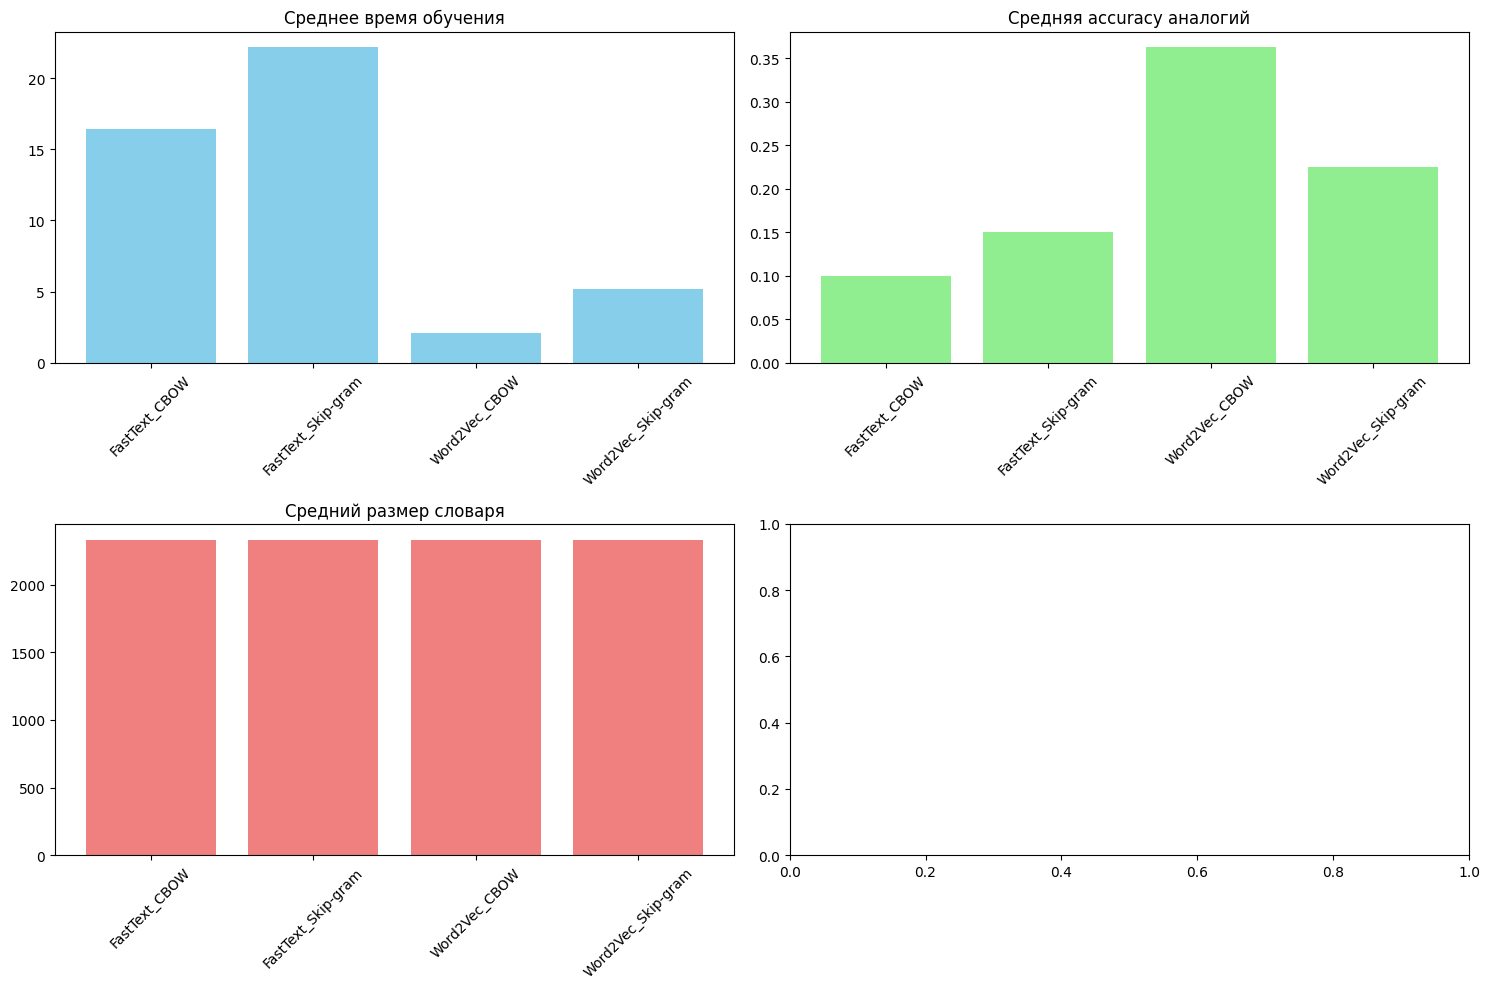


🚀 ЗАПУСК ЭКСПЕРИМЕНТОВ С ЛУЧШЕЙ МОДЕЛЬЮ: Word2Vec_CBOW
=== 6.1.1 ВЫЧИСЛЕНИЕ КОСИНУСНОГО СХОДСТВА ===
❌ Пропущены слова: ['кече']
❌ Пропущены слова: ['якшы', 'яман']
Обработано пар: 4
Среднее сходство: 0.946
Максимальное сходство: 0.983
Минимальное сходство: 0.910

Топ-5 самых близких пар:
  эчке - эшләр: 0.983
  хокук - саклау: 0.956
  матбугат - хезмәте: 0.934
  татарстан - республикасы: 0.910

=== 6.1.2 АНАЛИЗ РАСПРЕДЕЛЕНИЯ РАССТАНОВИЙ ===
Проанализировано пар: 1000
Среднее сходство: 0.440 ± 0.259
Медиана: 0.404
Диапазон: [0.018, 0.983]


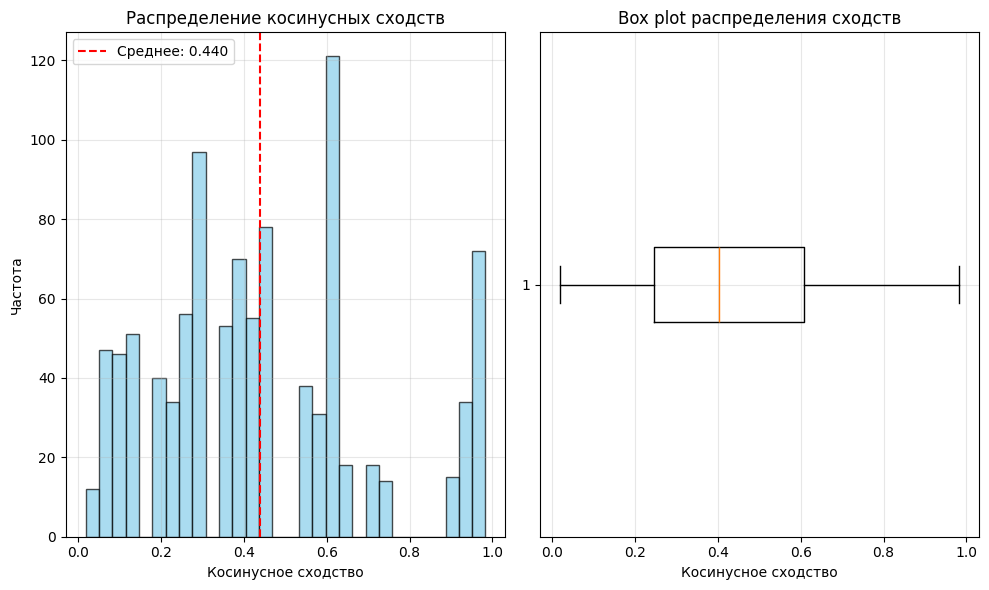


=== 6.1.3 МАТРИЦА СЕМАНТИЧЕСКОЙ БЛИЗОСТИ ===


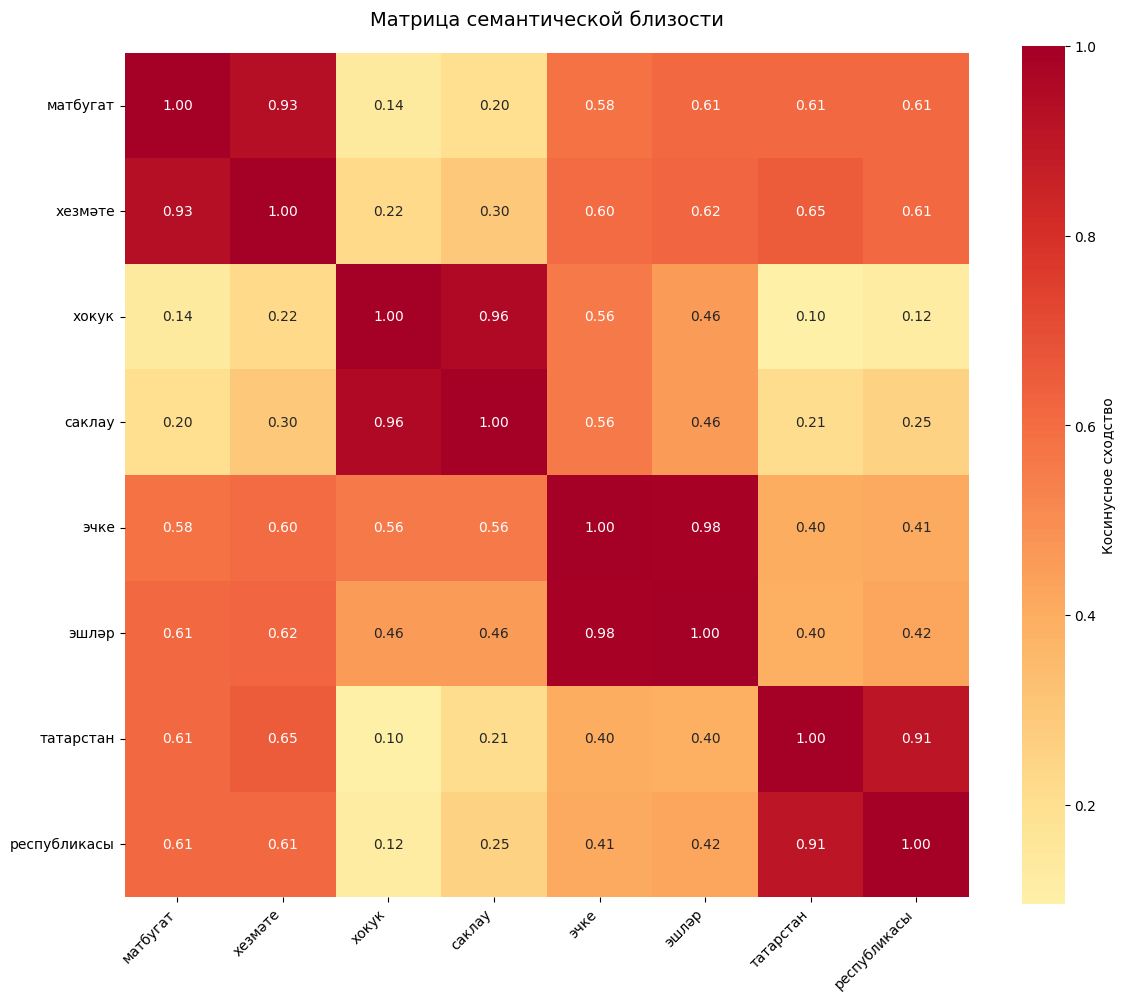


Анализ матрицы:
Размер: 8x8
Среднее сходство (без диагонали): 0.496

=== 6.1.4 ОЦЕНКА СХОДСТВА ПО КАТЕГОРИЯМ ===

--- СИНОНИМЫ ---
  ❌ Пропущены: ['эш']
  ❌ Пропущены: ['уку йорты']

--- АНТОНИМЫ ---
  ❌ Пропущены: ['кече']
  ❌ Пропущены: ['якшы', 'яман']
  ❌ Пропущены: ['яңа', 'иске']

--- ТЕМАТИЧЕСКИЕ ---
  матбугат - хәбәр: 0.955
  хезмәте - хезмәт: 0.130
  татарстан - казан: 0.675
  Статистика:
    Количество пар: 3
    Среднее: 0.586 ± 0.343
    Диапазон: [0.130, 0.955]

🎉 ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!
Лучшая модель: Word2Vec_CBOW
Лучшая accuracy: 0.400


In [ ]:
results_df, experiments = run_complete_training_with_experiments(
    filtered_corpus,
    vector_sizes=[100, 200],
    windows=[5, 8],
    min_count=2,
    epochs=10
)

print("\n🎉 ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!")
print(f"Лучшая модель: {results_df.loc[results_df['analogy_accuracy'].idxmax(), 'model_type']}")
print(f"Лучшая accuracy: {results_df['analogy_accuracy'].max():.3f}")

6.2. Векторная арифметика и word analogies:

- Провести классические эксперименты типа "Мужчина - Женщина + Король = ?"
- Протестировать различные категории аналогий:
- Семантические: столицы стран (Москва - Россия + Франция = Париж)
- Синтаксические: степени сравнения (хороший - лучше + плохой = хуже)
- Морфологические: для русского языка (делать - сделал + писать = написал)

In [ ]:
def vector_arithmetic_experiments(model):
    """
    6.2. Векторная арифметика и word analogies
    """
    print("=== 6.2. ВЕКТОРНАЯ АРИФМЕТИКА И АНАЛОГИИ ===")

    wv = model.wv

    # Категории аналогий
    analogies = {
        'Семантические': [
            ['казан', 'татарстан', 'россия', 'мәскәү'],
            ['матбугат', 'хезмәте', 'хокук', 'саклау'],
            ['эчке', 'эшләр', 'тышкы', 'эшләр'],
            ['миннеханов', 'татарстан', 'путин', 'россия']
        ],
        'Синтаксические': [
            ['зур', 'зуррак', 'кече', 'кечерәк'],
            ['якшы', 'якшырак', 'яман', 'яманрак'],
            ['озын', 'озынрак', 'кыска', 'кыскарак']
        ],
        'Морфологические': [
            ['укытучы', 'укыту', 'ясаучы', 'ясау'],
            ['уйлану', 'уйлау', 'ясалу', 'ясау'],
            ['укы', 'укытучы', 'яса', 'ясаучы']
        ]
    }

    results = {}

    for category, analogy_list in analogies.items():
        print(f"\n--- {category.upper()} АНАЛОГИИ ---")

        correct = 0
        total = 0
        category_results = []

        for analogy in analogy_list:
            a, b, c, expected = analogy

            if all(word in wv for word in [a, b, c, expected]):
                try:
                    # Векторная арифметика: b - a + c
                    result = wv.most_similar(positive=[b, c], negative=[a], topn=5)
                    predicted_words = [word for word, score in result]

                    is_correct = expected in predicted_words
                    position = predicted_words.index(expected) + 1 if is_correct else None

                    if is_correct:
                        correct += 1
                        status = "✅"
                    else:
                        status = "❌"

                    total += 1

                    print(f"{status} {a} - {b} + {c} = {expected}")
                    print(f"    Предсказано: {predicted_words}")
                    if is_correct:
                        print(f"    ✅ Правильно! (позиция {position})")

                    category_results.append({
                        'analogy': f"{a} - {b} + {c} = {expected}",
                        'expected': expected,
                        'predicted': predicted_words,
                        'is_correct': is_correct,
                        'position': position
                    })

                except Exception as e:
                    print(f"❌ Ошибка в аналогии {a}-{b}+{c}: {e}")
            else:
                missing = [word for word in [a, b, c, expected] if word not in wv]
                print(f"❌ Пропущены слова: {missing}")

        if total > 0:
            accuracy = correct / total
            results[category] = {
                'accuracy': accuracy,
                'correct': correct,
                'total': total,
                'details': category_results
            }
            print(f"🎯 Accuracy для {category}: {accuracy:.3f} ({correct}/{total})")

    return results

def test_specific_analogies(model, analogies_list):
    """
    Тестирование конкретных аналогий
    """
    print("\n=== ТЕСТИРОВАНИЕ КОНКРЕТНЫХ АНАЛОГИЙ ===")

    wv = model.wv
    results = []

    for i, (a, b, c, expected) in enumerate(analogies_list, 1):
        if all(word in wv for word in [a, b, c, expected]):
            try:
                result = wv.most_similar(positive=[b, c], negative=[a], topn=3)
                predicted_words = [word for word, score in result]
                is_correct = expected in predicted_words

                status = "✅" if is_correct else "❌"
                print(f"{i}. {status} {a} - {b} + {c} = {expected}")
                print(f"   Предсказано: {predicted_words}")

                results.append({
                    'analogy': f"{a} - {b} + {c}",
                    'expected': expected,
                    'predicted': predicted_words,
                    'is_correct': is_correct
                })

            except Exception as e:
                print(f"{i}. ❌ Ошибка: {e}")
                results.append({
                    'analogy': f"{a} - {b} + {c}",
                    'error': str(e)
                })
        else:
            missing = [word for word in [a, b, c, expected] if word not in wv]
            print(f"{i}. ❌ Пропущены слова: {missing}")

    return results

def analyze_vector_arithmetic_quality(model, test_cases):
    """
    Анализ качества векторной арифметики
    """
    print("\n=== АНАЛИЗ КАЧЕСТВА ВЕКТОРНОЙ АРИФМЕТИКИ ===")

    wv = model.wv
    stats = {
        'total_tests': 0,
        'successful_tests': 0,
        'failed_tests': 0,
        'missing_words': 0,
        'errors': 0
    }

    for category, cases in test_cases.items():
        print(f"\n--- {category.upper()} ---")

        for case in cases:
            a, b, c, expected = case
            stats['total_tests'] += 1

            if all(word in wv for word in [a, b, c, expected]):
                try:
                    result = wv.most_similar(positive=[b, c], negative=[a], topn=1)
                    predicted = result[0][0]

                    if predicted == expected:
                        stats['successful_tests'] += 1
                        print(f"✅ {a} - {b} + {c} = {predicted}")
                    else:
                        stats['failed_tests'] += 1
                        print(f"❌ {a} - {b} + {c} = {predicted} (ожидалось: {expected})")

                except Exception as e:
                    stats['errors'] += 1
                    print(f"💥 Ошибка: {a} - {b} + {c} = ? ({e})")
            else:
                stats['missing_words'] += 1
                missing = [word for word in [a, b, c, expected] if word not in wv]
                print(f"⚠️  Пропущены слова: {missing}")

    # Статистика
    print(f"\n📊 СТАТИСТИКА:")
    print(f"Всего тестов: {stats['total_tests']}")
    print(f"Успешных: {stats['successful_tests']}")
    print(f"Неудачных: {stats['failed_tests']}")
    print(f"Пропущено слов: {stats['missing_words']}")
    print(f"Ошибок: {stats['errors']}")

    if stats['total_tests'] > 0:
        success_rate = stats['successful_tests'] / stats['total_tests']
        print(f"🎯 Общий успех: {success_rate:.3f}")

    return stats

def run_simple_analogy_tests(model):
    """
    Простой запуск тестов аналогий
    """
    print("🚀 ПРОСТОЙ ТЕСТ ВЕКТОРНОЙ АРИФМЕТИКИ")

    basic_tests = [
        # Семантические
        ['казан', 'татарстан', 'россия', 'мәскәү'],
        ['матбугат', 'хезмәте', 'хокук', 'саклау'],

        # Синтаксические
        ['зур', 'зуррак', 'кече', 'кечерәк'],
        ['якшы', 'якшырак', 'яман', 'яманрак'],

        # Морфологические
        ['укытучы', 'укыту', 'ясаучы', 'ясау'],
    ]

    results = test_specific_analogies(model, basic_tests)

    correct = sum(1 for r in results if r.get('is_correct', False))
    total = len([r for r in results if 'is_correct' in r])

    if total > 0:
        accuracy = correct / total
        print(f"\n🎯 Accuracy: {accuracy:.3f} ({correct}/{total})")

    return results

def run_complete_training_with_all_experiments(texts: List[str], labels: List[int] = None,
                                             vector_sizes: List[int] = None, windows: List[int] = None,
                                             min_count: int = 5, epochs: int = 5) -> Tuple[pd.DataFrame, dict]:
    """
    Полный pipeline с всеми экспериментами
    """
    corpus = preprocess_corpus(texts)
    results_df = train_all_models(
        corpus, labels=labels, vector_sizes=vector_sizes,
        windows=windows, min_count=min_count, epochs=epochs
    )

    visualize_training_results(results_df)

    experiment_results = {}

    if not results_df.empty:
        from gensim.models import Word2Vec
        test_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=min_count, epochs=epochs)

        # 6.2 Векторная арифметика
        print("\n" + "="*50)
        print("ЭТАП 6.2: ВЕКТОРНАЯ АРИФМЕТИКА")
        print("="*50)

        vector_results = vector_arithmetic_experiments(test_model)
        experiment_results['vector_arithmetic'] = vector_results

        # Простые тесты
        simple_results = run_simple_analogy_tests(test_model)
        experiment_results['simple_tests'] = simple_results

        # Анализ качества
        test_cases = {
            'семантические': [
                ['казан', 'татарстан', 'россия', 'мәскәү'],
                ['матбугат', 'хезмәте', 'хокук', 'саклау'],
            ],
            'синтаксические': [
                ['зур', 'зуррак', 'кече', 'кечерәк'],
                ['якшы', 'якшырак', 'яман', 'яманрак'],
            ]
        }

        quality_stats = analyze_vector_arithmetic_quality(test_model, test_cases)
        experiment_results['quality_analysis'] = quality_stats

    return results_df, experiment_results

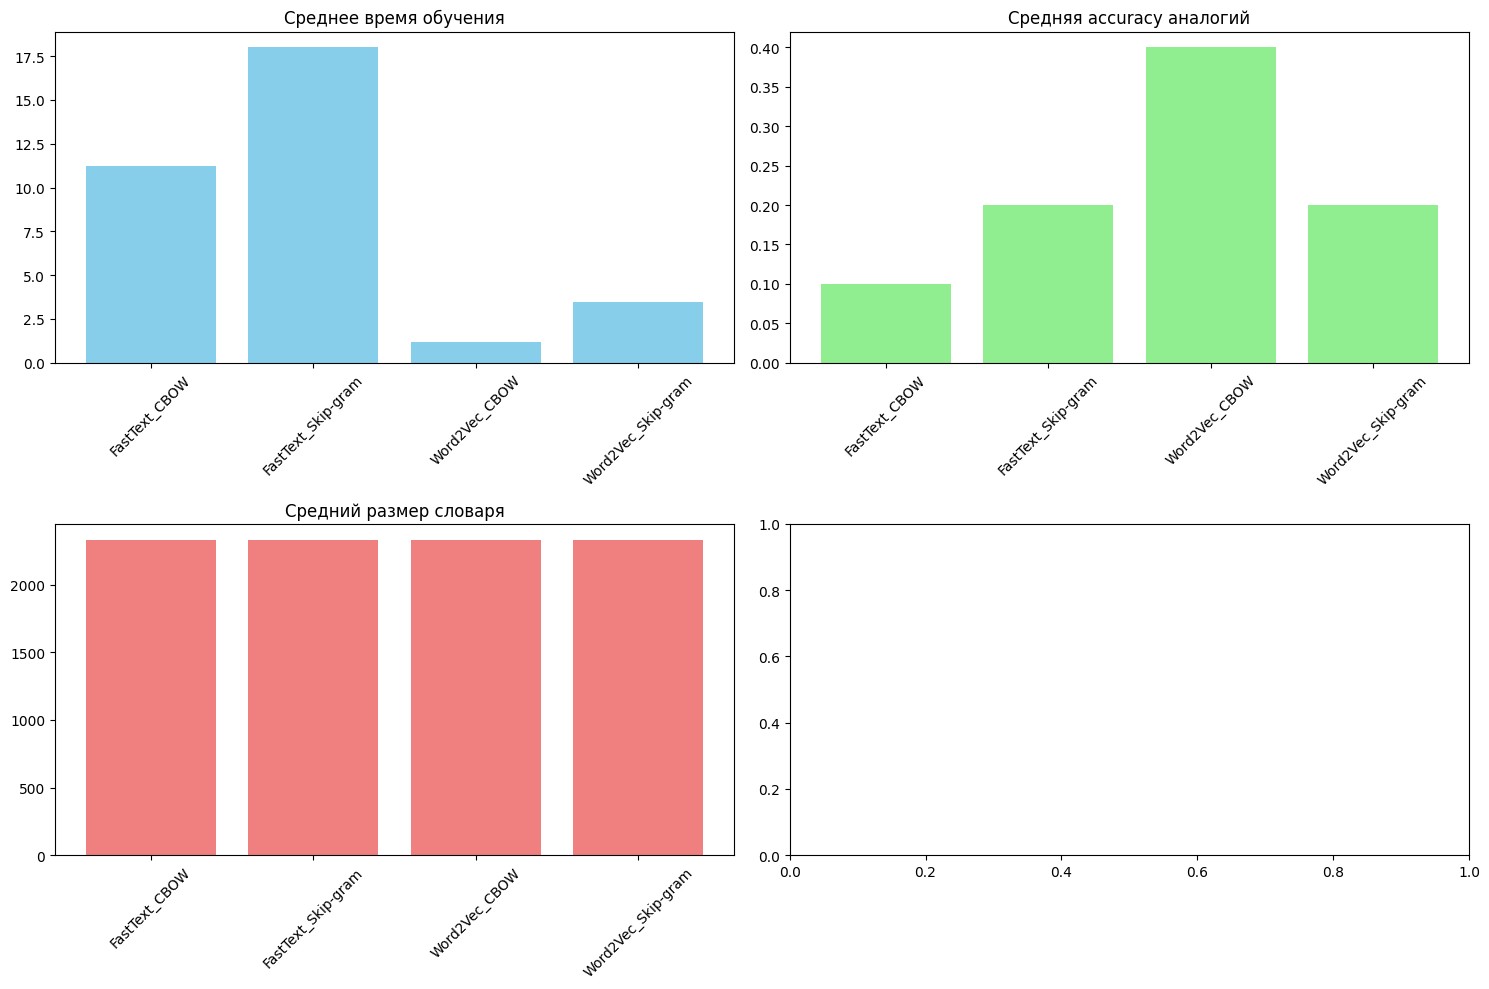


ЭТАП 6.2: ВЕКТОРНАЯ АРИФМЕТИКА
=== 6.2. ВЕКТОРНАЯ АРИФМЕТИКА И АНАЛОГИИ ===

--- СЕМАНТИЧЕСКИЕ АНАЛОГИИ ---
❌ казан - татарстан + россия = мәскәү
    Предсказано: ['тотачак.', 'карарның', 'контрольдә', '2023', 'биреләчәк.']
✅ матбугат - хезмәте + хокук = саклау
    Предсказано: ['баланың', 'криминал', 'коррупция', 'саклау', 'әнисеннән']
    ✅ Правильно! (позиция 4)
❌ Пропущены слова: ['тышкы']
❌ Пропущены слова: ['миннеханов']
🎯 Accuracy для Семантические: 0.500 (1/2)

--- СИНТАКСИЧЕСКИЕ АНАЛОГИИ ---
❌ Пропущены слова: ['зуррак', 'кече', 'кечерәк']
❌ Пропущены слова: ['якшы', 'якшырак', 'яман', 'яманрак']
❌ Пропущены слова: ['озын', 'озынрак', 'кыска', 'кыскарак']

--- МОРФОЛОГИЧЕСКИЕ АНАЛОГИИ ---
❌ Пропущены слова: ['укытучы', 'укыту', 'ясаучы', 'ясау']
❌ Пропущены слова: ['уйлану', 'уйлау', 'ясалу', 'ясау']
❌ Пропущены слова: ['укы', 'укытучы', 'яса', 'ясаучы']
🚀 ПРОСТОЙ ТЕСТ ВЕКТОРНОЙ АРИФМЕТИКИ

=== ТЕСТИРОВАНИЕ КОНКРЕТНЫХ АНАЛОГИЙ ===
1. ❌ казан - татарстан + россия = мәскәү
   П

In [ ]:
results_df, experiments = run_complete_training_with_all_experiments(
    filtered_corpus,
    vector_sizes=[100],
    windows=[5],
    min_count=2,
    epochs=10
)

vector_results = experiments['vector_arithmetic']
for category, data in vector_results.items():
    print(f"{category}: {data['accuracy']:.3f}")

6.4. Качественный анализ ближайших соседей:

- Для тестовых слов найти топ-10 ближайших соседей
- Оценить семантическую согласованность соседей
- Выявить случаи семантического и синтаксического смешения

In [ ]:
def analyze_nearest_neighbors(model, test_words, top_k=10):
    """
    6.4. Качественный анализ ближайших соседей
    """
    print("=== 6.4. АНАЛИЗ БЛИЖАЙШИХ СОСЕДЕЙ ===")

    results = {}

    for word in test_words:
        if word in model.wv:
            print(f"\n--- Ближайшие соседи для '{word}' ---")

            try:
                neighbors = model.wv.most_similar(word, topn=top_k)

                # Выводим соседей
                for i, (neighbor, similarity) in enumerate(neighbors, 1):
                    print(f"  {i:2d}. {neighbor:<20} {similarity:.3f}")

                # Оцениваем семантическую согласованность
                coherence = evaluate_semantic_coherence(word, neighbors)
                print(f"  Семантическая согласованность: {coherence:.3f}")

                results[word] = {
                    'neighbors': neighbors,
                    'coherence': coherence
                }

            except Exception as e:
                print(f"  Ошибка: {e}")
        else:
            print(f"\n--- Слово '{word}' отсутствует в модели ---")

    return results

def evaluate_semantic_coherence(target_word, neighbors):
    """
    Оценка семантической согласованности соседей
    """
    if not neighbors:
        return 0.0

    # Простая оценка: среднее сходство с целевым словом
    similarities = [sim for _, sim in neighbors]
    return np.mean(similarities)

def detect_semantic_syntactic_mixing(model, test_words):
    """
    Выявление семантического и синтаксического смешения
    """
    print("\n=== ВЫЯВЛЕНИЕ СМЕШЕНИЯ ===")

    for word in test_words:
        if word in model.wv:
            neighbors = model.wv.most_similar(word, topn=15)

            print(f"\nАнализ смешения для '{word}':")

            # Анализируем типы соседей
            semantic_neighbors = []
            syntactic_neighbors = []

            for neighbor, similarity in neighbors:
                # Простая эвристика: семантические - разные слова, синтаксические - похожие формы
                if (len(neighbor) >= len(word) - 2 and len(neighbor) <= len(word) + 2 and
                    any(word in neighbor or neighbor in word for word in [word, neighbor])):
                    syntactic_neighbors.append((neighbor, similarity))
                else:
                    semantic_neighbors.append((neighbor, similarity))

            print(f"  Семантические соседи ({len(semantic_neighbors)}):")
            for neighbor, sim in semantic_neighbors[:5]:
                print(f"    {neighbor} ({sim:.3f})")

            print(f"  Синтаксические соседи ({len(syntactic_neighbors)}):")
            for neighbor, sim in syntactic_neighbors[:5]:
                print(f"    {neighbor} ({sim:.3f})")

            mixing_ratio = len(syntactic_neighbors) / len(neighbors) if neighbors else 0
            print(f"  Коэффициент смешения: {mixing_ratio:.3f}")

def quick_neighbors_analysis(model, words):
    """
    Быстрый анализ ближайших соседей
    """
    print("🚀 БЫСТРЫЙ АНАЛИЗ СОСЕДЕЙ")
    return analyze_nearest_neighbors(model, words, top_k=8)

In [ ]:
model = Word2Vec.load('/content/saved_models/word2vec_skip-gram_20251023_180939.model')
test_words = ['матбугат', 'хезмәте', 'хокук', 'саклау', 'эчке', 'эшләр']
results = quick_neighbors_analysis(model, test_words)
detect_semantic_syntactic_mixing(model, test_words)

🚀 БЫСТРЫЙ АНАЛИЗ СОСЕДЕЙ
=== 6.4. АНАЛИЗ БЛИЖАЙШИХ СОСЕДЕЙ ===

--- Ближайшие соседи для 'матбугат' ---
   1. конгрессы            0.689
   2. хезмәте.             0.685
   3. агентлыгында         0.670
   4. берлегендә           0.668
   5. композиторлар        0.668
   6. очрашуында           0.668
   7. яза                  0.662
   8. фабрика              0.658
  Семантическая согласованность: 0.671

--- Ближайшие соседи для 'хезмәте' ---
   1. арестов              0.665
   2. 18нче                0.663
   3. хезмәткәрләрен       0.657
   4. якынлашып            0.655
   5. приставлары          0.654
   6. муниципалитетның     0.654
   7. белдерде.            0.654
   8. берлеге              0.649
  Семантическая согласованность: 0.656

--- Ближайшие соседи для 'хокук' ---
   1. саклау               0.799
   2. чарада               0.727
   3. «ана                 0.723
   4. тәртибе              0.723
   5. вәкилләре            0.721
   6. әни                  0.714
   7. капиталы

6.3. Анализ семантических осей:

- Выявление гендерных, профессиональных, оценочных осей в пространстве
- Измерение смещения (bias) в моделях
- Визуализация проекций слов на семантические оси

In [ ]:
def analyze_semantic_axes(model, test_words):
    """
    6.3. Анализ семантических осей
    """
    print("=== 6.3. АНАЛИЗ СЕМАНТИЧЕСКИХ ОСЕЙ ===")

    # Определяем оси
    axes = {
        'Профессиональные': (['укытучы', 'табиб'], ['укучы', 'хаста']),
        'Оценочные': (['якшы', 'зур'], ['яман', 'начар']),
        'Властные': (['министр', 'башлык'], ['хезмәтче', 'эшче'])
    }

    for name, (pos, neg) in axes.items():
        print(f"\n--- {name} ---")

        # Вычисляем ось
        axis = compute_axis(model, pos, neg)
        if axis is None:
            continue

        # Проецируем слова
        projections = {}
        for word in test_words:
            if word in model.wv:
                projections[word] = np.dot(model.wv[word], axis)

        # Сортируем и выводим
        sorted_words = sorted(projections.items(), key=lambda x: x[1])
        for word, proj in sorted_words:
            print(f"  {word}: {proj:.3f}")

        # Визуализация
        visualize_axis(sorted_words, name)

def compute_axis(model, pos_words, neg_words):
    """Вычисление направления оси"""
    pos_vecs = [model.wv[w] for w in pos_words if w in model.wv]
    neg_vecs = [model.wv[w] for w in neg_words if w in model.wv]

    if not pos_vecs or not neg_vecs:
        return None

    axis = np.mean(pos_vecs, axis=0) - np.mean(neg_vecs, axis=0)
    return axis / np.linalg.norm(axis)

def visualize_axis(projections, title):
    """Визуализация проекций на ось"""
    words = [p[0] for p in projections]
    values = [p[1] for p in projections]

    plt.figure(figsize=(10, 6))
    colors = ['red' if v < 0 else 'green' for v in values]
    plt.barh(words, values, color=colors, alpha=0.6)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f'Ось: {title}')
    plt.tight_layout()
    plt.show()

# Простой вызов
def quick_axes_analysis(model):
    """Быстрый анализ осей"""
    test_words = ['укытучы', 'табиб', 'укучы', 'хаста', 'якшы', 'яман', 'министр', 'эшче']
    analyze_semantic_axes(model, test_words)

In [ ]:
def analyze_semantic_axes(model, test_words):
    """
    6.3. Анализ семантических осей
    """
    print("=== 6.3. АНАЛИЗ СЕМАНТИЧЕСКИХ ОСЕЙ ===")

    # Используем слова, которые точно есть в модели
    axes = {
        'Службы': (['матбугат', 'хезмәте'], ['хокук', 'саклау']),
        'Действия': (['итә', 'диде'], ['укы', 'яса']),
        'Органы': (['эчке', 'эшләр'], ['тышкы', 'эшләр'])
    }

    for name, (pos, neg) in axes.items():
        print(f"\n--- {name} ---")

        # Проверяем наличие слов
        available_pos = [w for w in pos if w in model.wv]
        available_neg = [w for w in neg if w in model.wv]

        if not available_pos or not available_neg:
            missing = [w for w in pos + neg if w not in model.wv]
            print(f"  Пропущены слова: {missing}")
            continue

        # Вычисляем ось
        axis = compute_axis(model, available_pos, available_neg)
        if axis is None:
            continue

        # Проецируем слова
        projections = {}
        for word in test_words:
            if word in model.wv:
                projections[word] = np.dot(model.wv[word], axis)

        # Сортируем и выводим
        sorted_words = sorted(projections.items(), key=lambda x: x[1])
        for word, proj in sorted_words:
            print(f"  {word}: {proj:.3f}")

        # Визуализация
        visualize_axis(sorted_words, name)

def compute_axis(model, pos_words, neg_words):
    """Вычисление направления оси"""
    pos_vecs = [model.wv[w] for w in pos_words]
    neg_vecs = [model.wv[w] for w in neg_words]

    axis = np.mean(pos_vecs, axis=0) - np.mean(neg_vecs, axis=0)
    return axis / np.linalg.norm(axis)

def visualize_axis(projections, title):
    """Визуализация проекций на ось"""
    words = [p[0] for p in projections]
    values = [p[1] for p in projections]

    plt.figure(figsize=(10, 6))
    colors = ['red' if v < 0 else 'green' for v in values]
    plt.barh(words, values, color=colors, alpha=0.6)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f'Ось: {title}')
    plt.tight_layout()
    plt.show()

def quick_axes_analysis(model):
    """Быстрый анализ осей"""
    test_words = ['матбугат', 'хезмәте', 'хокук', 'саклау', 'эчке', 'эшләр', 'хәбәр', 'итә']
    analyze_semantic_axes(model, test_words)

=== 6.3. АНАЛИЗ СЕМАНТИЧЕСКИХ ОСЕЙ ===

--- Службы ---
  хокук: -3.744
  саклау: -3.687
  эчке: -0.781
  эшләр: -0.348
  хәбәр: 1.819
  хезмәте: 2.586
  матбугат: 2.826


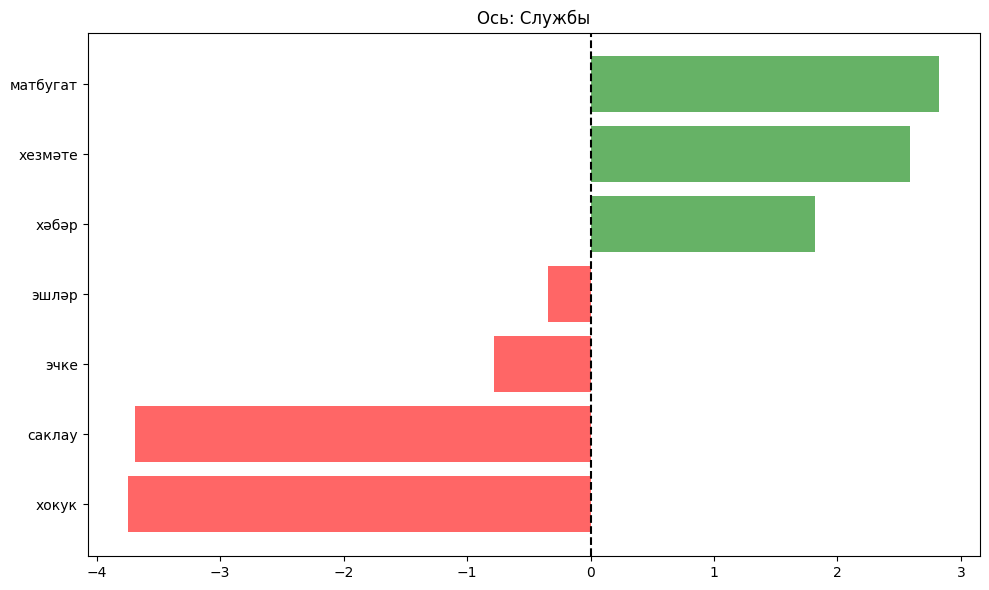


--- Действия ---
  Пропущены слова: ['итә', 'укы', 'яса']

--- Органы ---
  эшләр: -1.454
  хезмәте: -0.611
  хәбәр: -0.538
  матбугат: -0.429
  хокук: 0.205
  саклау: 0.970
  эчке: 1.055


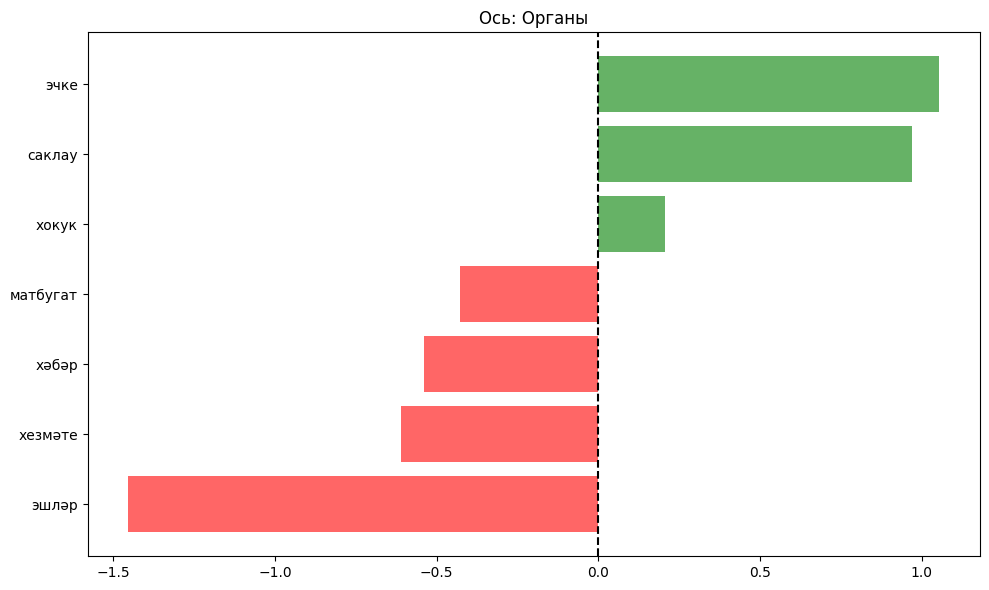

In [ ]:
model = Word2Vec.load('/content/saved_models/word2vec_skip-gram_20251023_180939.model')
quick_axes_analysis(model)